In [1]:
import igraph as ig
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score as AMI
import partition_igraph
from matplotlib import pyplot as plt
from collections import Counter
import random
import pickle
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from scipy.sparse import csr_matrix
import scipy.sparse as sparse 
import time
from statistics import mode
from abcd_graph import ABCDGraph, ABCDParams
import csv
import subprocess
import sys
sys.path.append('../')
from CAS import *


In [4]:
## this assumes community 0 are outliers and 'gt' exists in graph G
## M: membership matrix
## S: score matrix (C or Beta)
def outliers_AUC(G, M, S):
    y = [int(x>0) for x in G.vs['gt']]
    x = np.array(S.max(axis=1).todense()).flatten()
    ctr = Counter(np.array(M.sum(axis=1)).flatten())
    print('With matrix M:\noutliers:',ctr[0])
    print('correct outliers:',sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(G.vs['gt']) == 0)))
    print('\nWith scores:\noutlier AUC:',AUC(y,x)) 
        

## ABCD-oo graphs

Main 2 files:

```
networkfile<xi>_<eta>_<rep>.txt : the edges, 1-based node ids, tab separated
communityfile<xi>_<eta>_<rep>.txt : node <tab> list of communities in [], for example:
1       [24]
2       [3, 28]
3       [10]
```

All files for one case:

```
communityfile0.5_1.5_10.txt
communitysizesfile0.5_1.5_10.txt
degreefile0.5_1.5_10.txt
networkfile0.5_1.5_10.txt
```

All graph have 250 outlier nodes, mapped to community 0 below


In [139]:
path = '/data/ABCDoo/'
#path = '../Datasets/ABCDoo/'
def readGraph(xi=0.5, eta=1.5, rep=1):
    ## read edges, build graph
    fn = path+'networkfile'+str(xi)+'_'+str(eta)+'_'+str(rep)+'.txt'
    Edges = pd.read_csv(fn, sep='\t', header=None)-1
    G = ig.Graph.DataFrame(Edges, directed=False)
    ## read communities
    fn = path+'communityfile'+str(xi)+'_'+str(eta)+'_'+str(rep)+'.txt'
    L = []
    with open(fn, "r") as infile:
        for line in infile:
            x = line.split('\t')
            L.append([int(y)-1 for y in x[1].rstrip()[1:-1].split(',')]) ## map to 0-based
    G.vs['comms'] = L
    G.vs['n_comms'] = [len(x) for x in G.vs['comms']]
    return G
   

In [140]:
#oNMI = '/Users/francois/Book/GraphMiningNotebooks/oNMI/onmi'          ## overlapping NMI executable
oNMI = '/work/home/fcthebe/Tools/oNMI/onmi'          ## overlapping NMI executable
def compute_oNMI(First, Second):
    fn1 = '__'+str(random.random())[2:]
    with open(fn1,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(First)
    f.close()   

    fn2 = '__'+str(random.random())[2:]
    with open(fn2,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(Second)
    f.close()   
    x = float(subprocess.check_output([oNMI,fn1,fn2]).decode("utf-8").split()[1])
    _ = os.system('rm '+fn1)
    _ = os.system('rm '+fn2)
    return x


In [415]:
def memberships2list(S):
    L = []
    for i in range(len(S.indptr)-1):
        if S.indptr[i] == S.indptr[i+1]:
            L.append([0]) ## no membership == outlier (community 0)
        else:
            L.append(list(S.indices[S.indptr[i]:S.indptr[i+1]]+1)) ## 1-based
    return L

def mem2comms(X):
    nc = max(set([i for j in X for i in j]))+1  
    n = len(X)
    L = [[] for _ in range(nc)]
    for i in range(n):
        for j in X[i]:
            L[j].append(i)
    return L

## Computing oNMI over a range of threshold values

In [541]:
%%time
TH = np.arange(10,331,10)/1000
Lst = []
rep = 1
Ldn = []

for eta in [1.0,1.5,2.0,2.5,3.0]:
    for xi in [.35,.5,.65]:
        for rep in [1,2,3,4,5,6,7,8,9,10]:
            G = readGraph(xi, eta, rep) 
            GT = mem2comms(G.vs['comms'])[1:]  ## ignore "outlier community"
            G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
            Leiden = mem2comms([[j] for j in G.vs['leiden']])
            ldn = compute_oNMI(GT, Leiden)
            print(eta, xi, rep, 'Leiden:', ldn)
            Ldn.append([eta,xi,ldn])
            IEF, Beta, C, Pv, DegPart = CAS(G.get_adjacency_sparse(), partition2sparse(G.vs['leiden']))
            for th1 in TH:
                non_outliers = np.array((Beta >= th1).sum(axis=1)>0).flatten()
                for th2 in TH:
                    if th2 <= th1:
                        L = []
                        for i in range(Beta.shape[1]):
                            x = np.where( (np.array(Beta[:,i].todense()).flatten() >= th2) & non_outliers)[0]
                            if len(x)>0:
                                L.append(list(x))
                        Lst.append([eta, xi, th1, th2, G.vcount() - sum(non_outliers), compute_oNMI(GT,L), sum([len(x) for x in L]) / sum(non_outliers)])
D = pd.DataFrame(Lst, columns=['eta', 'xi', 'th1', 'th2', 'outliers', 'oNMI','avg_membership'])
Leiden = pd.DataFrame(Ldn, columns=['eta','xi','oNMI'])
fn = 'dfs_onmi.pkl'
with open(fn,'wb') as fp:
    pickle.dump((D,Leiden),fp)
D.head()


1.0 0.35 1 Leiden: 0.954662
1.0 0.35 2 Leiden: 0.952284
1.0 0.35 3 Leiden: 0.944629
1.0 0.35 4 Leiden: 0.954267
1.0 0.35 5 Leiden: 0.955003
1.0 0.35 6 Leiden: 0.950155
1.0 0.35 7 Leiden: 0.953075
1.0 0.35 8 Leiden: 0.953752
1.0 0.35 9 Leiden: 0.950495
1.0 0.35 10 Leiden: 0.954341
1.0 0.5 1 Leiden: 0.94895
1.0 0.5 2 Leiden: 0.936682
1.0 0.5 3 Leiden: 0.885306
1.0 0.5 4 Leiden: 0.897812
1.0 0.5 5 Leiden: 0.911312
1.0 0.5 6 Leiden: 0.844782
1.0 0.5 7 Leiden: 0.923631
1.0 0.5 8 Leiden: 0.938099
1.0 0.5 9 Leiden: 0.912975
1.0 0.5 10 Leiden: 0.871839
1.0 0.65 1 Leiden: 0.459751
1.0 0.65 2 Leiden: 0.418673
1.0 0.65 3 Leiden: 0.443783
1.0 0.65 4 Leiden: 0.502044
1.0 0.65 5 Leiden: 0.624686
1.0 0.65 6 Leiden: 0.58651
1.0 0.65 7 Leiden: 0.596582
1.0 0.65 8 Leiden: 0.722327
1.0 0.65 9 Leiden: 0.546853
1.0 0.65 10 Leiden: 0.646387
1.5 0.35 1 Leiden: 0.318508
1.5 0.35 2 Leiden: 0.346633
1.5 0.35 3 Leiden: 0.338455
1.5 0.35 4 Leiden: 0.276266
1.5 0.35 5 Leiden: 0.311905
1.5 0.35 6 Leiden: 0.281093
1

,eta,xi,th1,th2,outliers,oNMI,avg_membership
0,1.0,0.35,0.01,0.01,0,0.097102,4.0833
1,1.0,0.35,0.02,0.01,0,0.097102,4.0833
2,1.0,0.35,0.02,0.02,0,0.126924,3.4827
3,1.0,0.35,0.03,0.01,0,0.097102,4.0833
4,1.0,0.35,0.03,0.02,0,0.126924,3.4827


In [539]:
D['clustered'] = (10000 - D.outliers)/10000
D['harmonic'] = 2/(1/D['oNMI'] + 1/D['clustered'])
D

,eta,xi,th1,th2,outliers,oNMI,avg_membership,clustered,harmonic
0,1.0,0.35,0.01,0.01,0,0.096997,4.085300,1.0000,0.176841
1,1.0,0.35,0.02,0.01,0,0.096997,4.085300,1.0000,0.176841
2,1.0,0.35,0.02,0.02,0,0.126903,3.482000,1.0000,0.225224
3,1.0,0.35,0.03,0.01,0,0.096997,4.085300,1.0000,0.176841
4,1.0,0.35,0.03,0.02,0,0.126903,3.482000,1.0000,0.225224
...,...,...,...,...,...,...,...,...,...
8410,3.0,0.65,0.33,0.29,8236,0.000000,1.001701,0.1764,0.000000
8411,3.0,0.65,0.33,0.30,8236,0.000000,1.000000,0.1764,0.000000
8412,3.0,0.65,0.33,0.31,8236,0.000000,1.000000,0.1764,0.000000
8413,3.0,0.65,0.33,0.32,8236,0.000000,1.000000,0.1764,0.000000


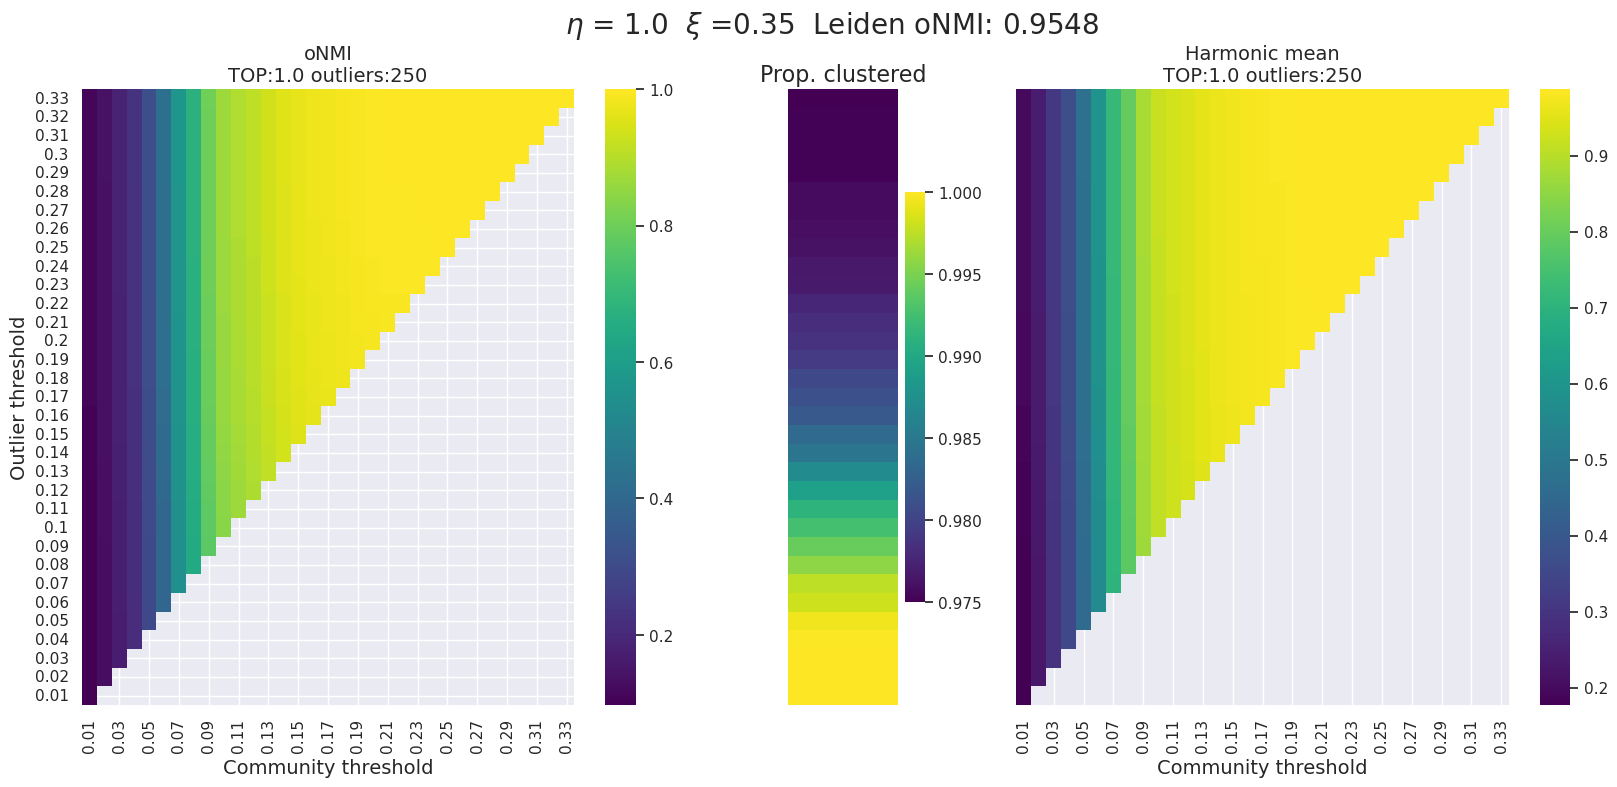

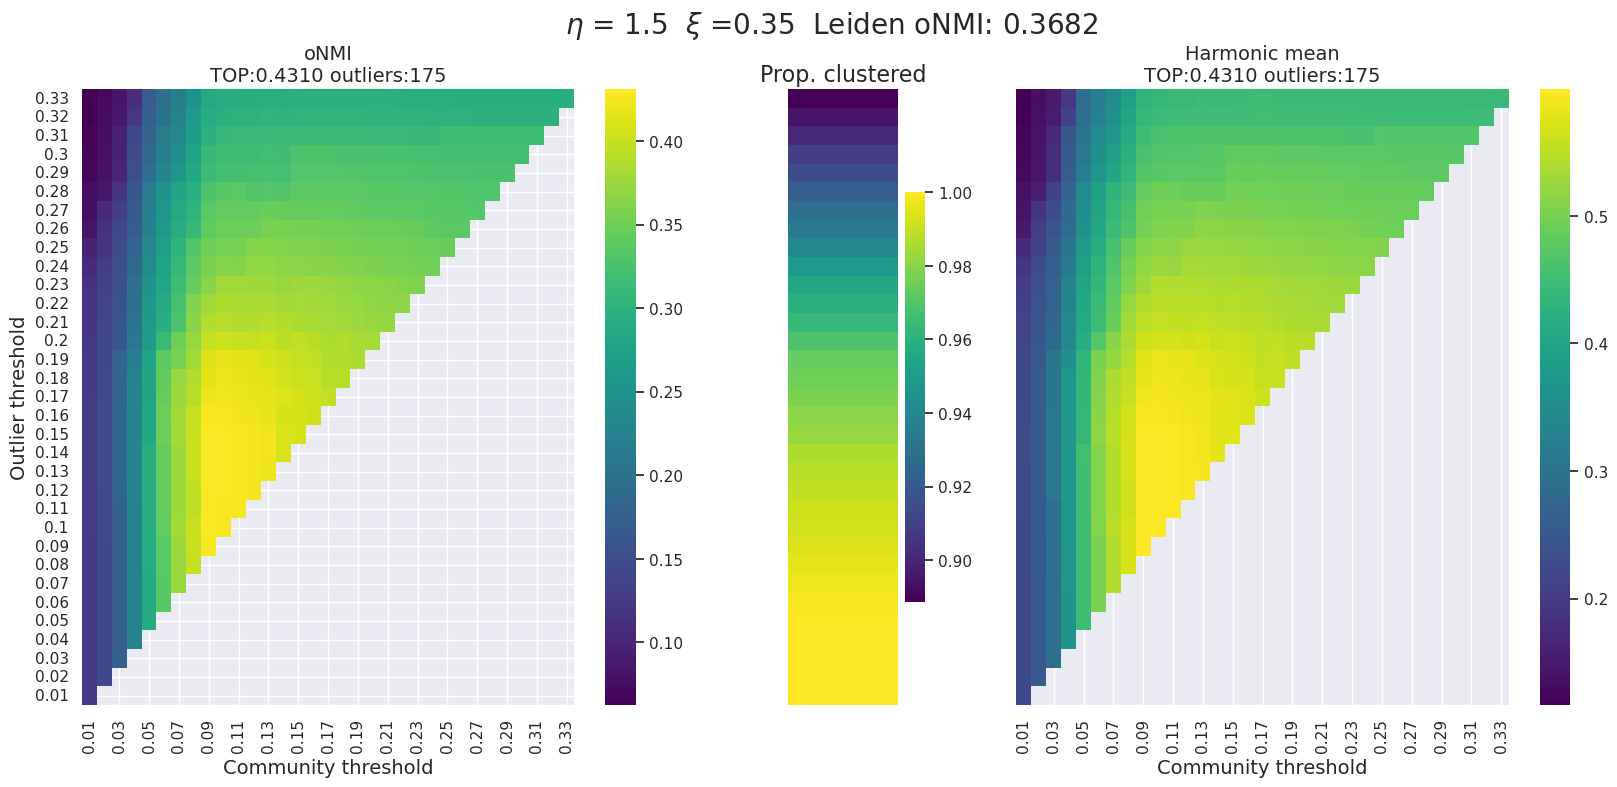

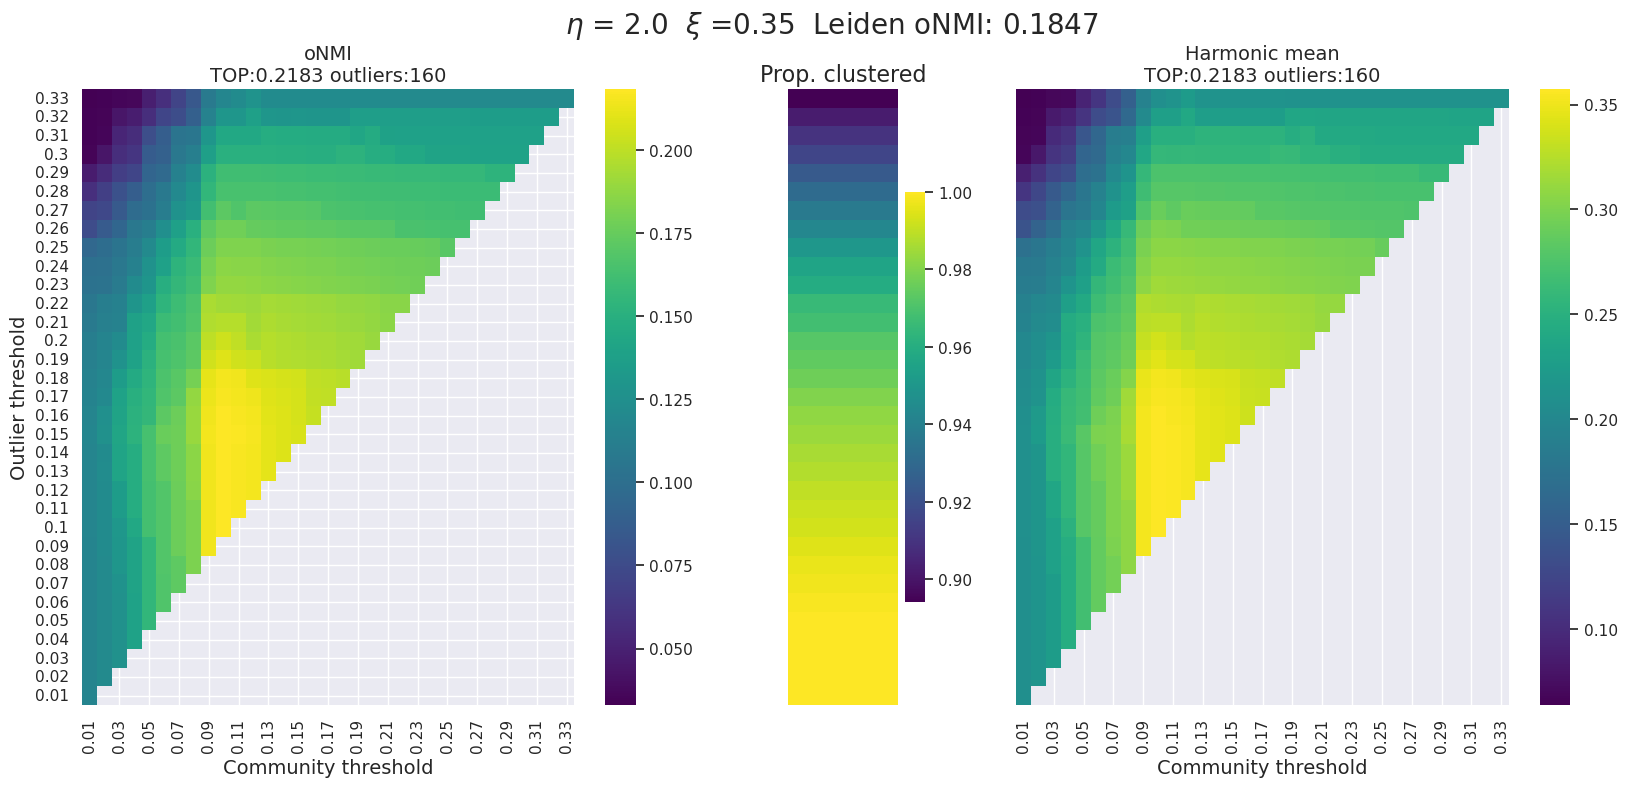

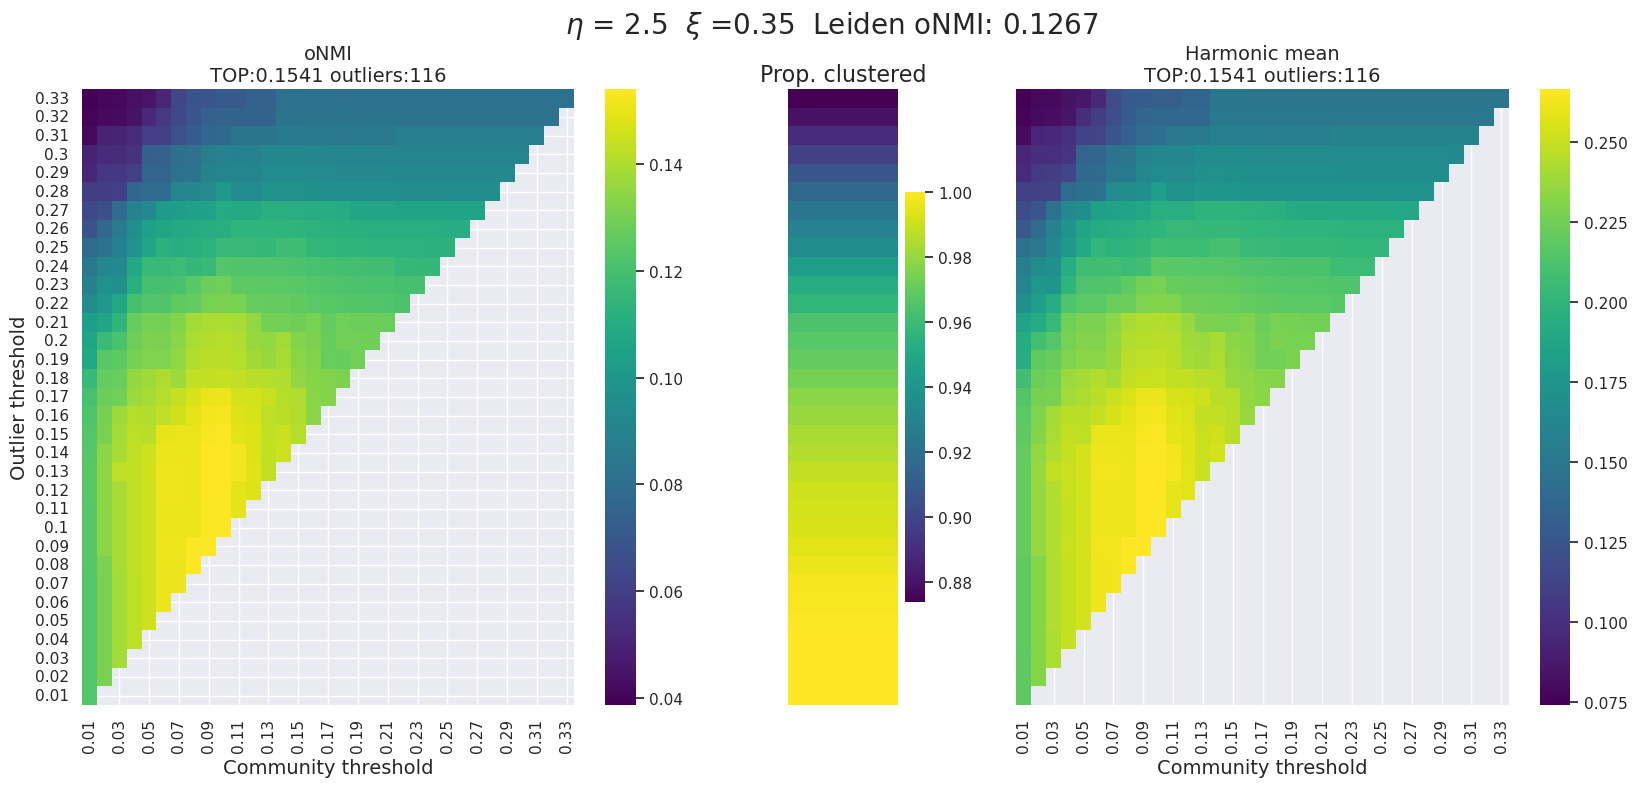

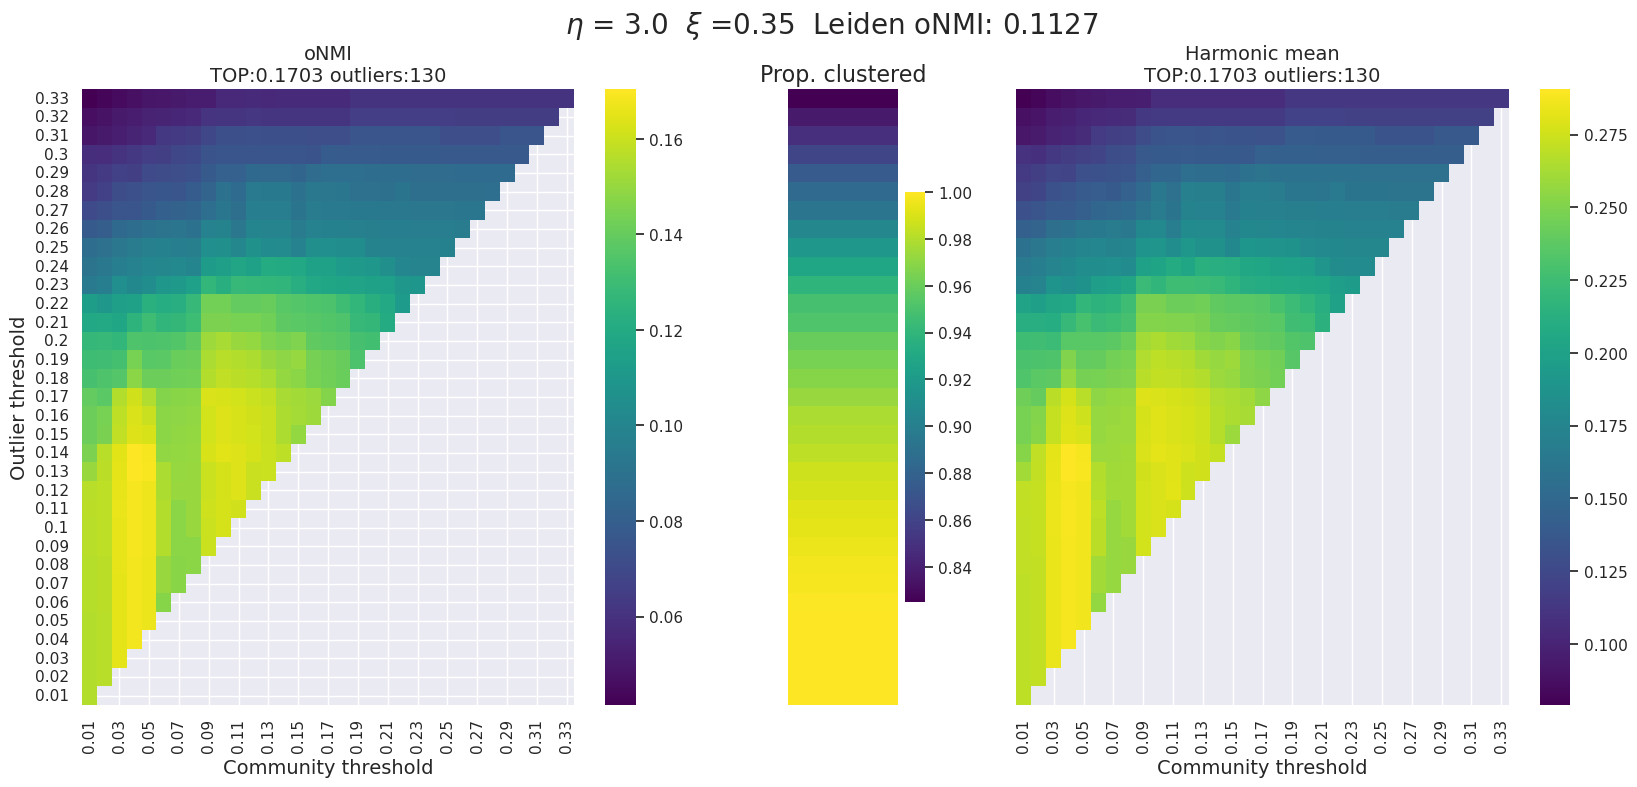

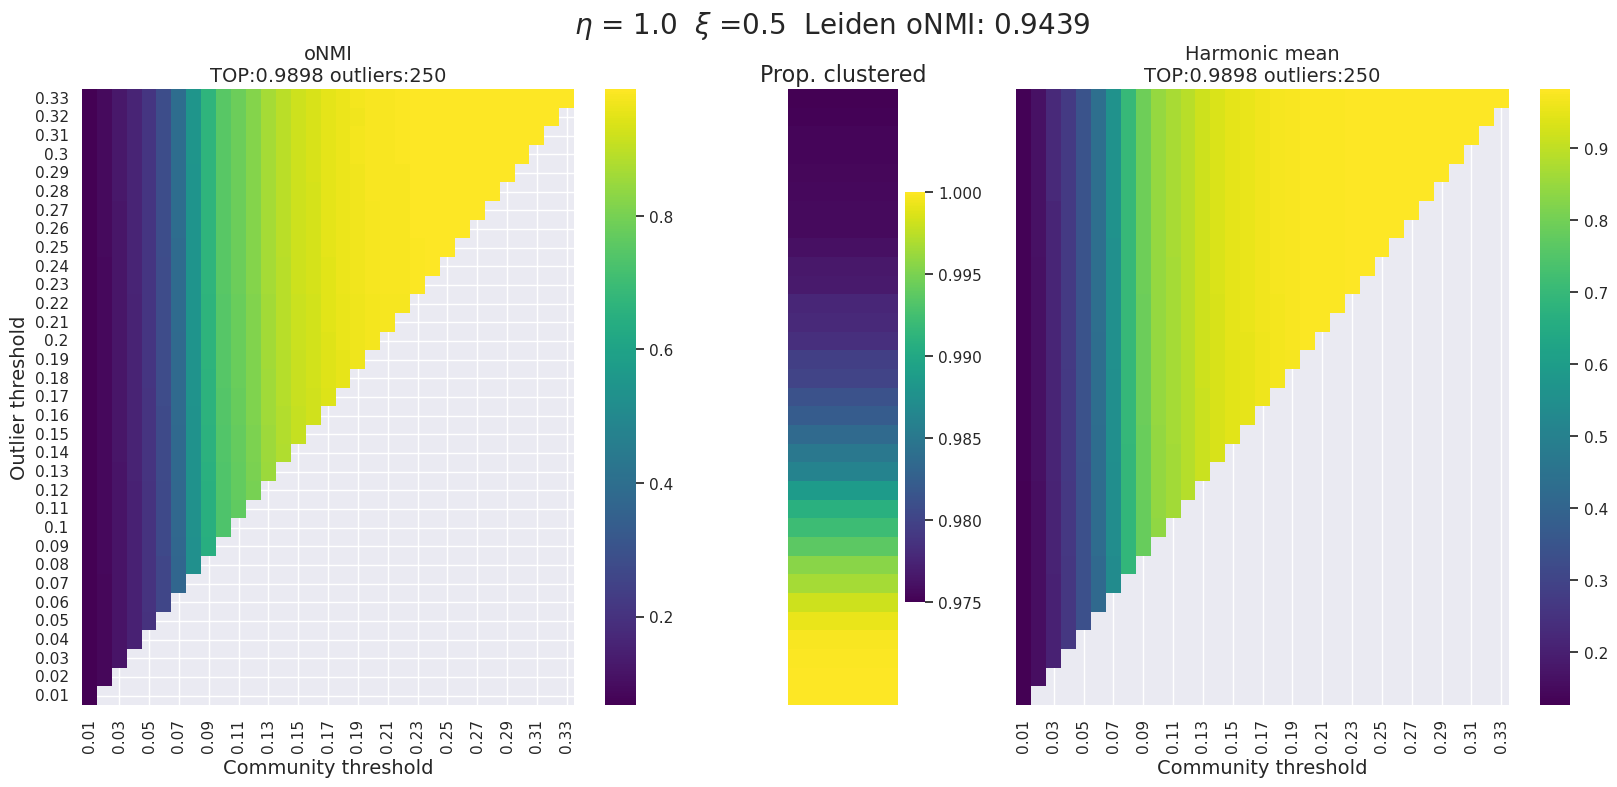

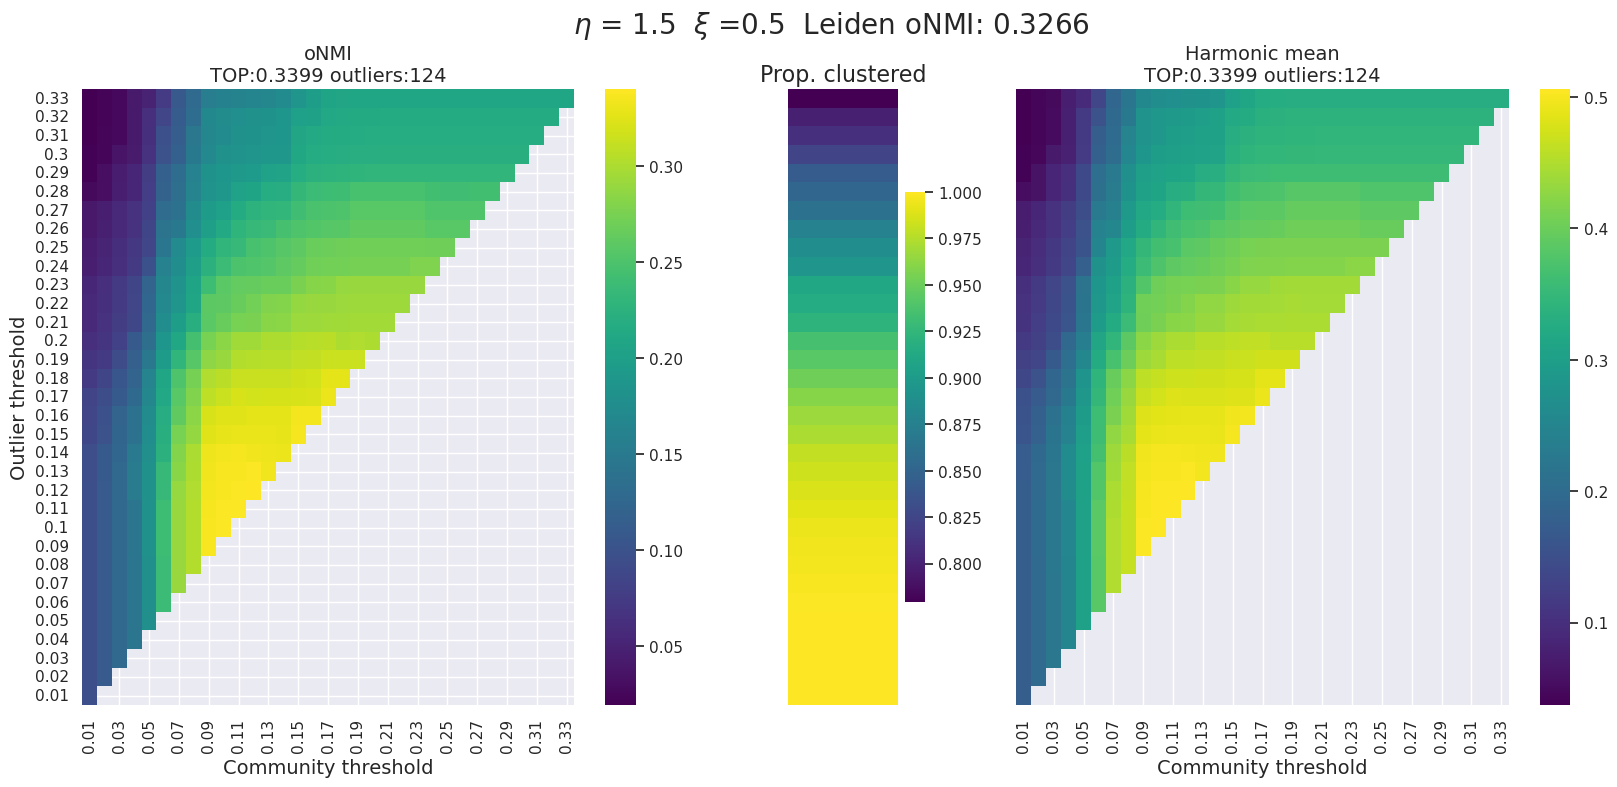

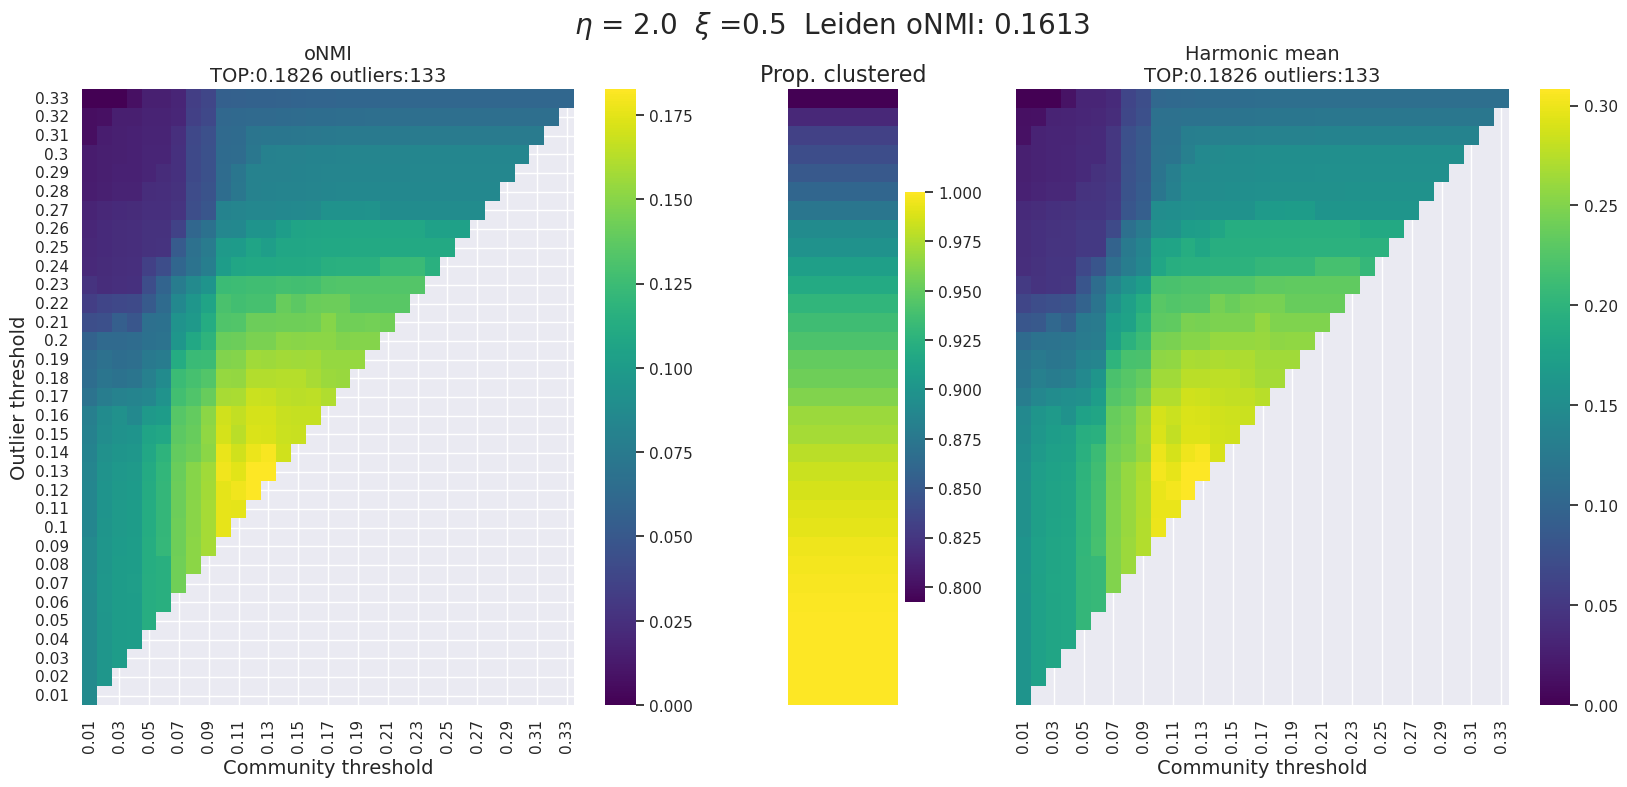

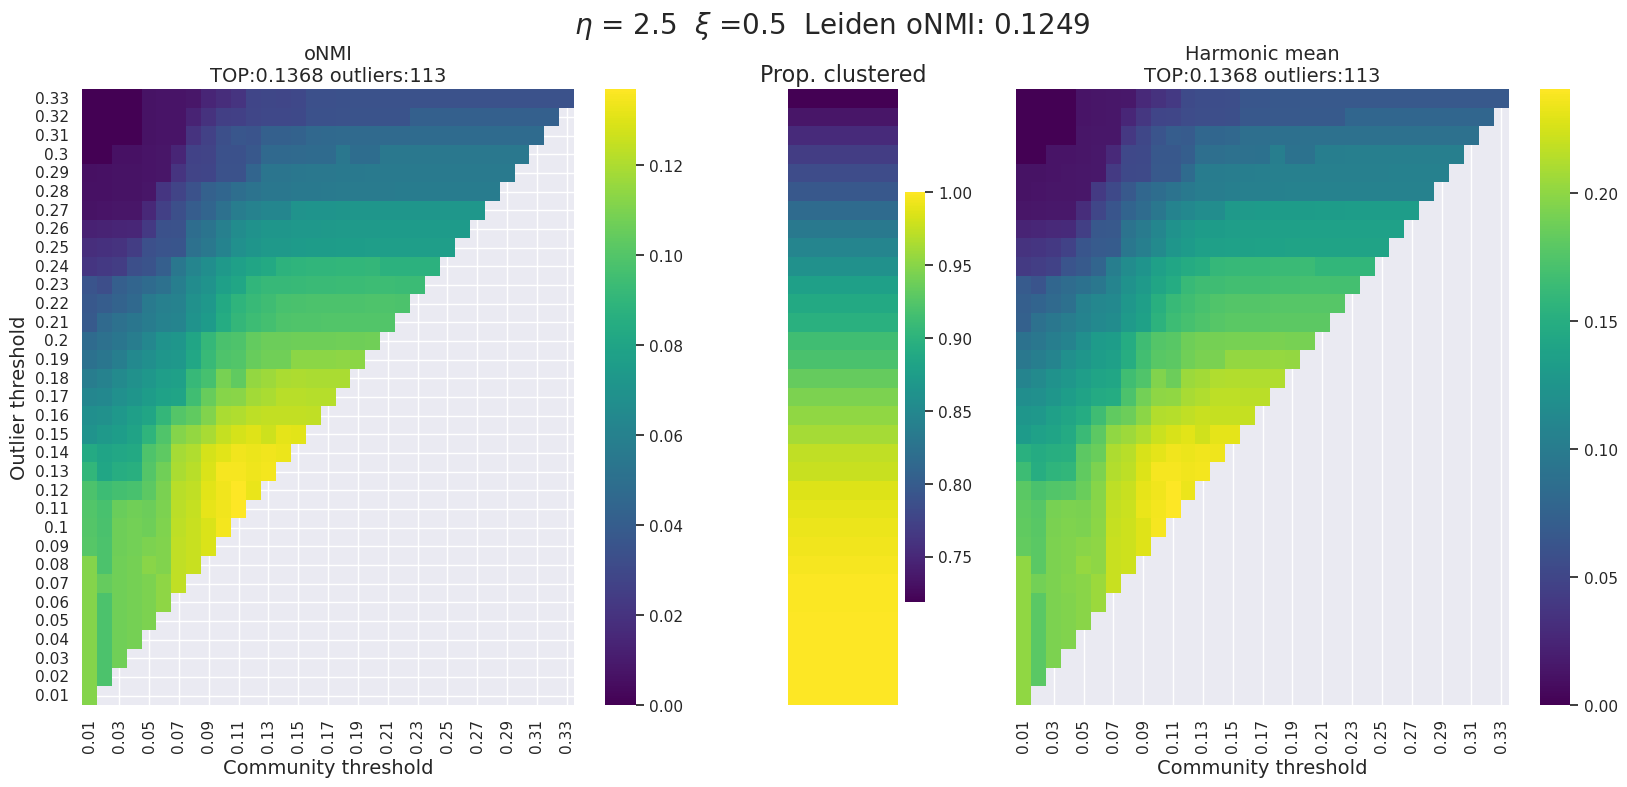

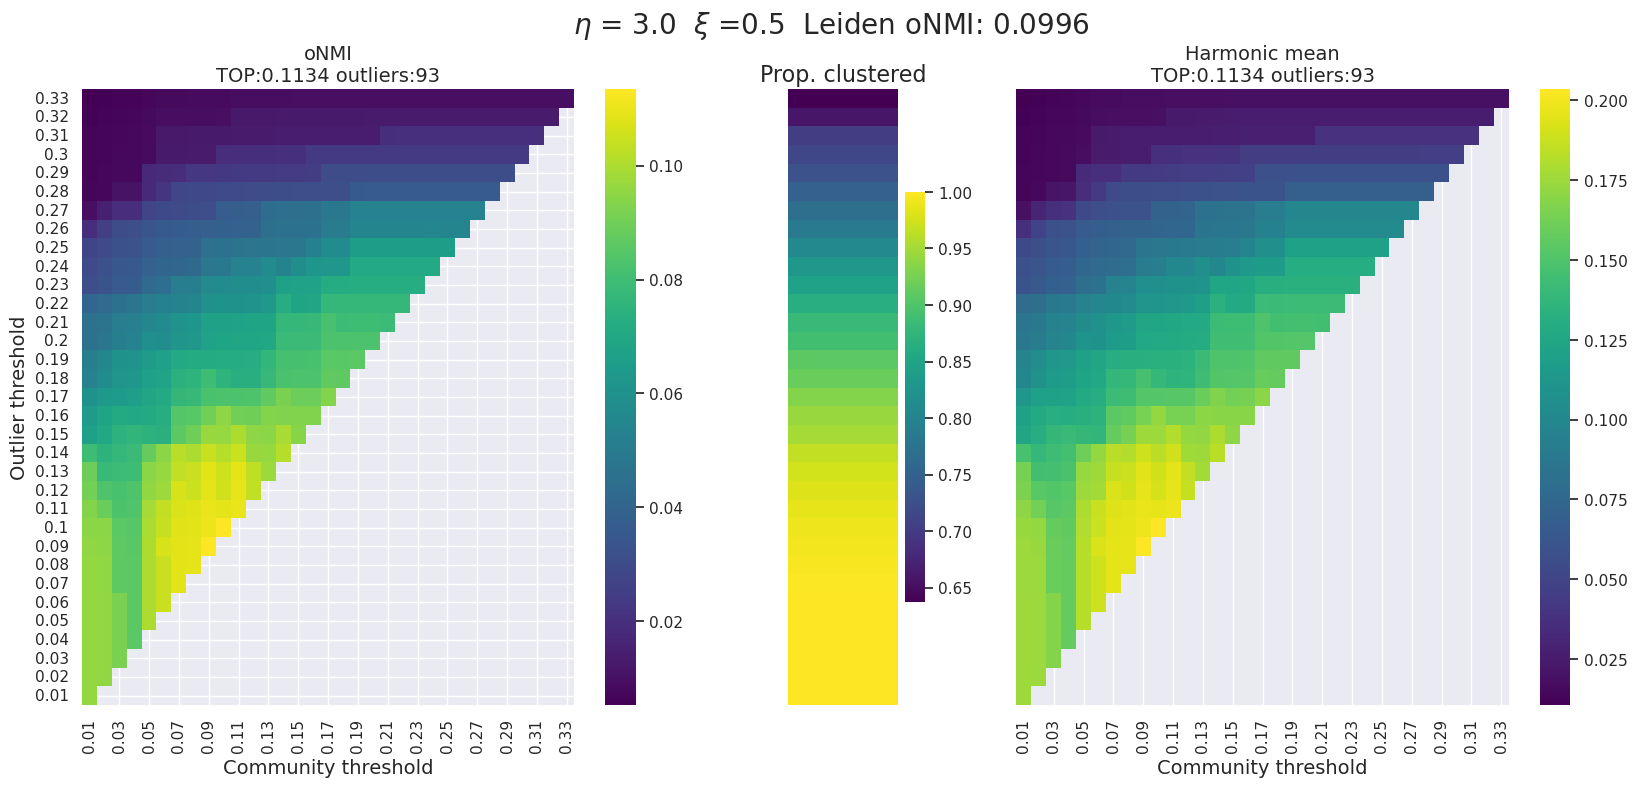

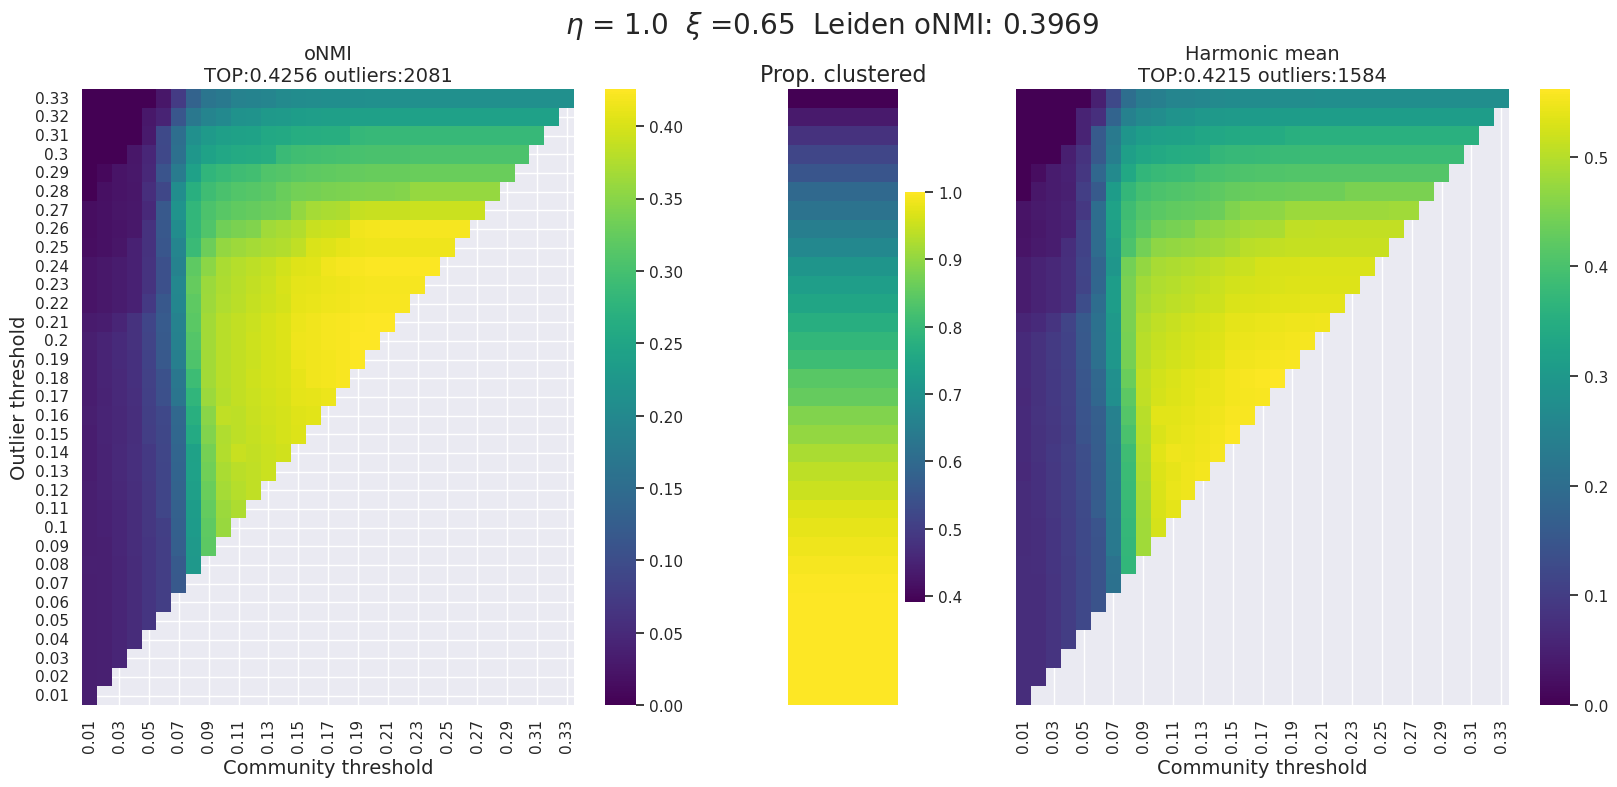

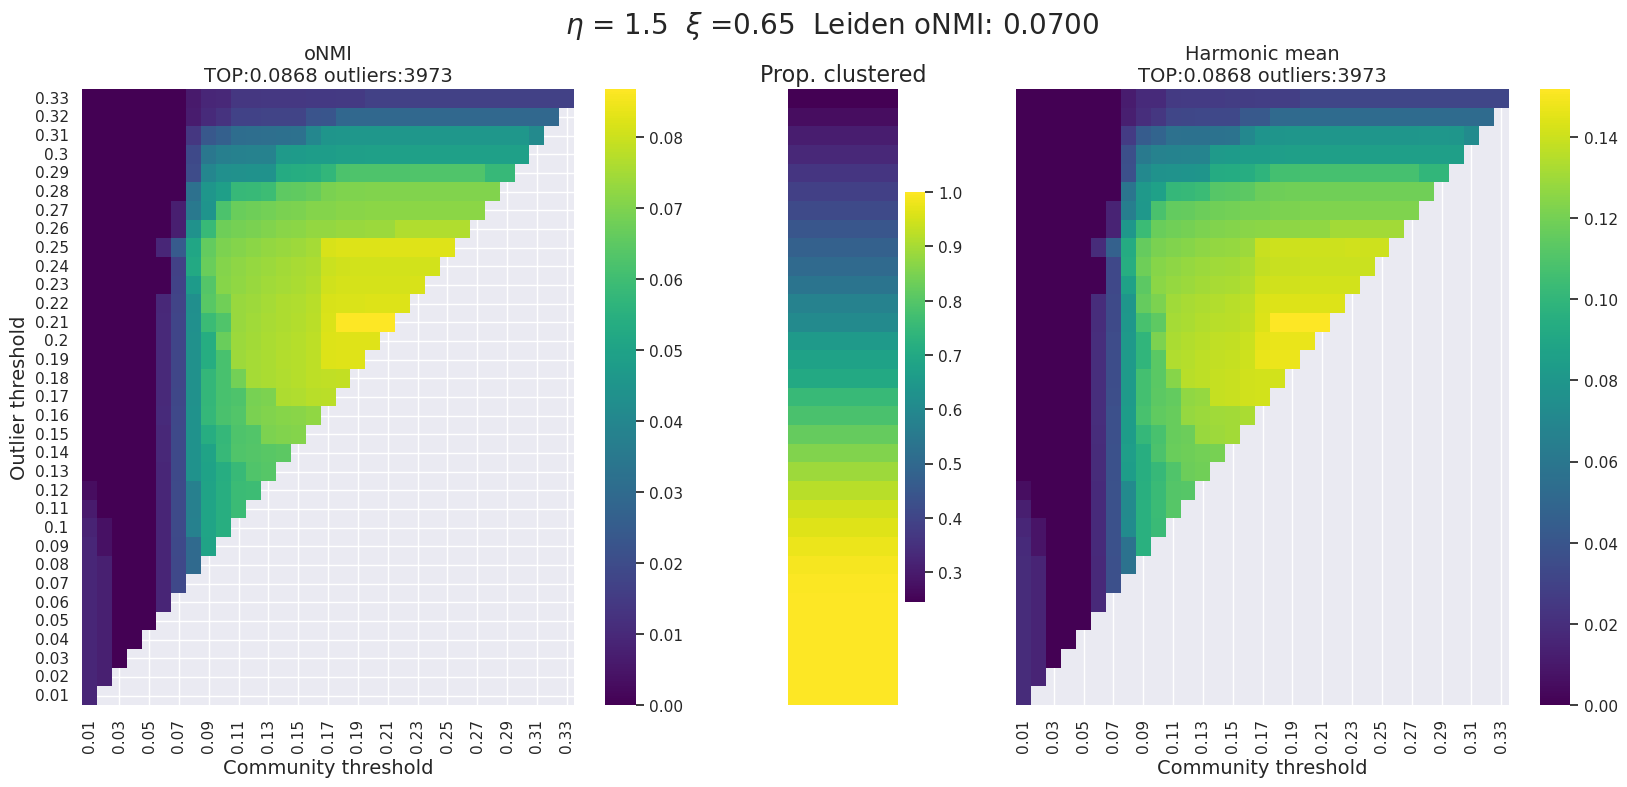

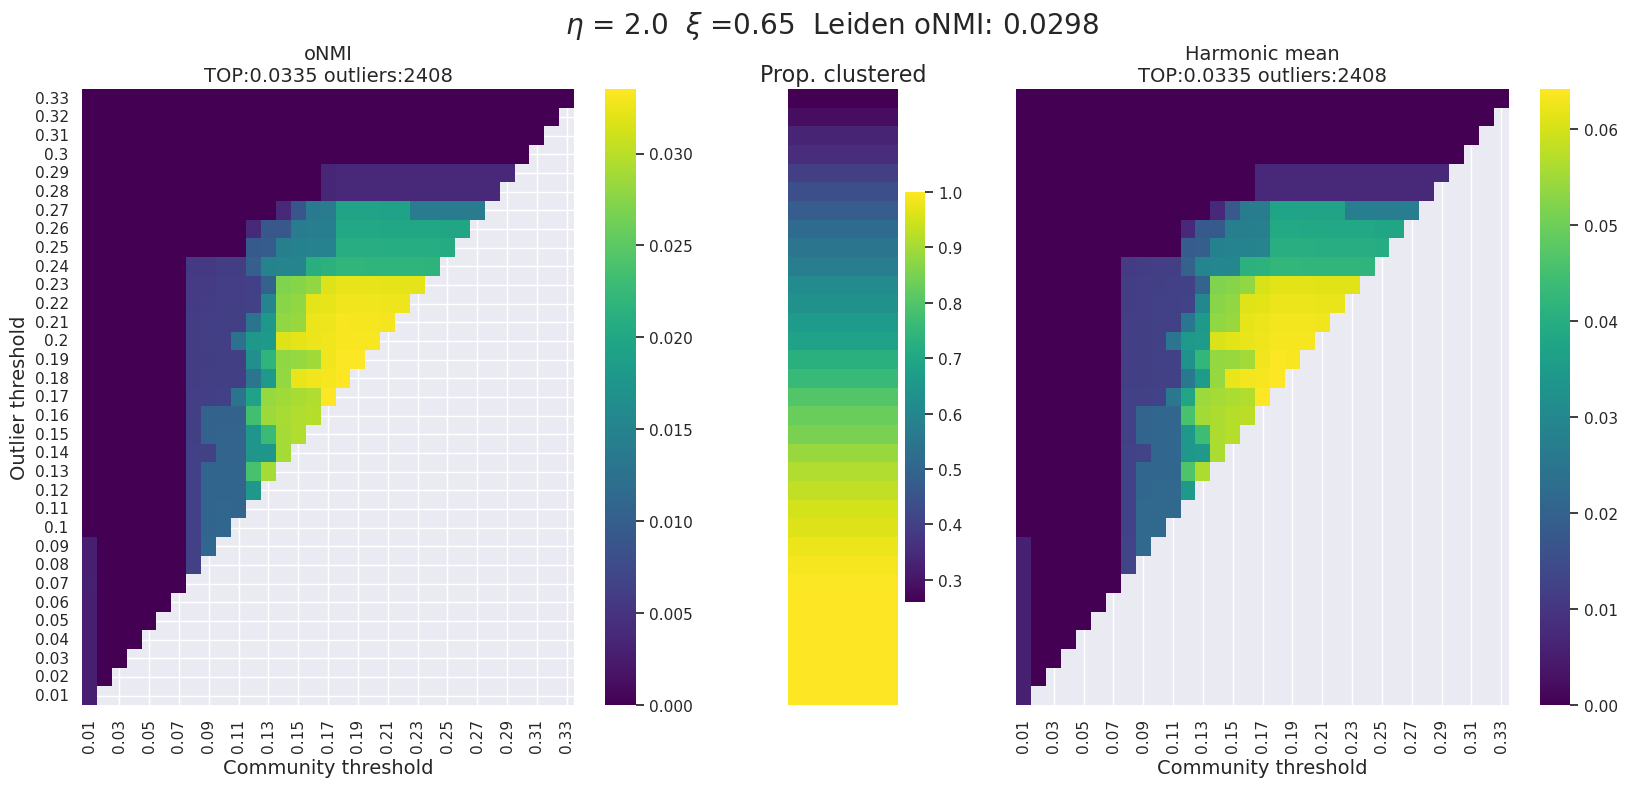

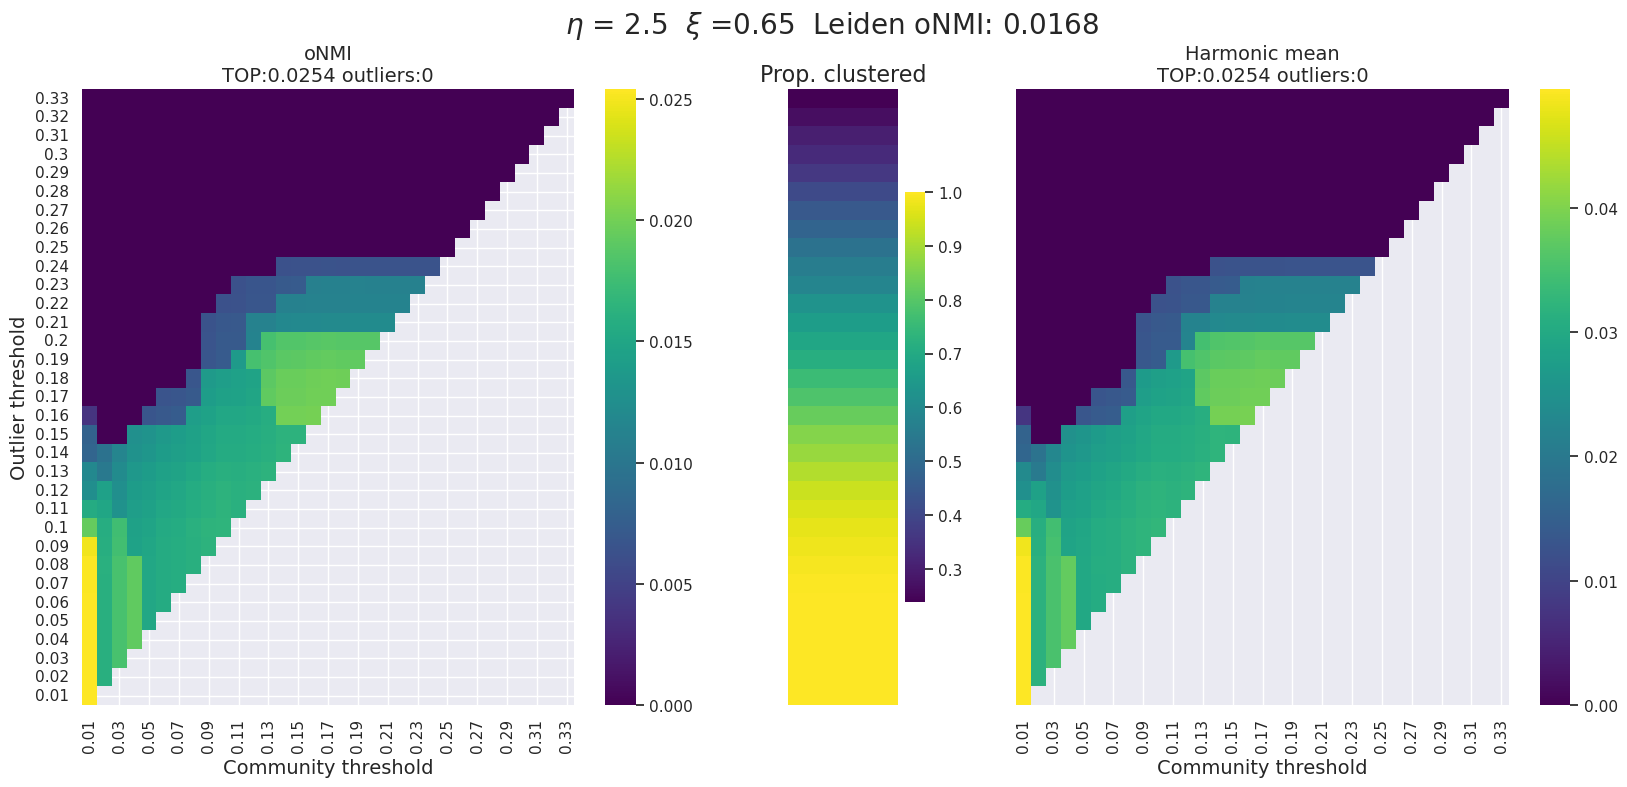

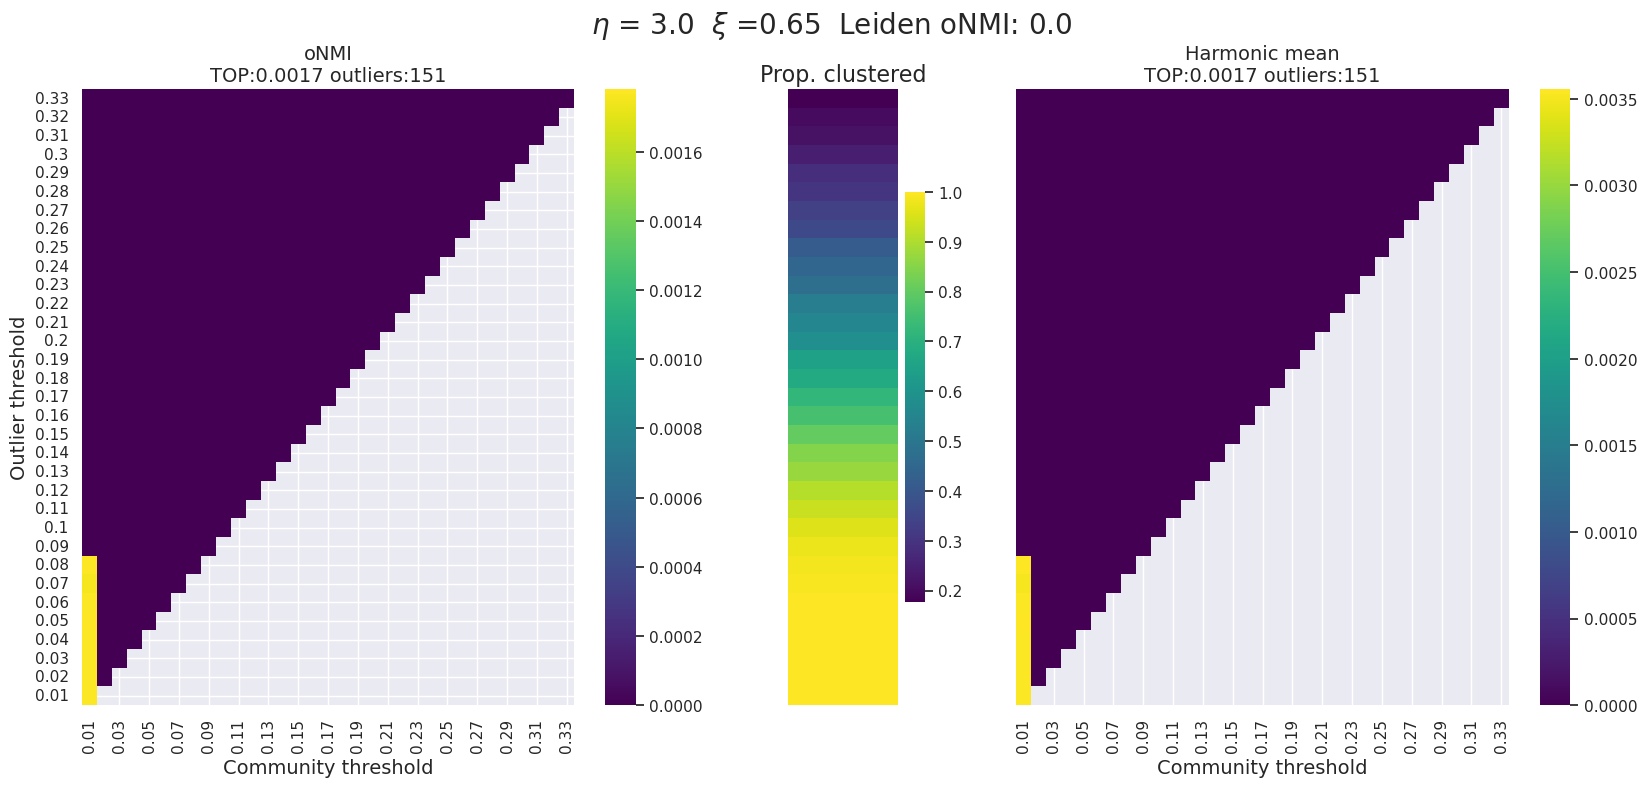

In [540]:
for xi in [.35,.5,.65]:
    for eta in [1.0,1.5,2.0,2.5,3.0]:

        df = D[ (D.xi==xi) & (D.eta==eta) ]
        Dm = df.groupby(by=['eta','xi','th1','th2'], as_index=False).mean()


        fig, ax = plt.subplots(1, 3, figsize=(20, 8), gridspec_kw={'width_ratios': [.45, .1, .45]})

        plt.subplot(1,3,1)
        X = Dm.pivot_table(
            index='th1',
            columns='th2',
            values='oNMI'
        )
        sns.heatmap(X, cmap='viridis')
        plt.ylim(0,33)
        plt.suptitle(r'$\eta$ = '+str(eta)+r'  $\xi$ ='+str(xi)+'  Leiden oNMI: '+str(Leiden[(Leiden.eta==eta) & (Leiden.xi==xi)].oNMI.iloc[0])[:6], fontsize=20)
        plt.title('oNMI\n'+'TOP:'+str(Dm.iloc[np.argmax(Dm.oNMI)]['oNMI'])[:6]+' outliers:'+str(int(np.round(Dm.iloc[np.argmax(Dm.oNMI)]['outliers']))), fontsize=14)
        plt.ylabel('Outlier threshold', fontsize=14)
        plt.xlabel('Community threshold', fontsize=14);

        plt.subplot(1,3,2)
        X = Dm.pivot_table(
            index='th1',
            columns='th2',
            values='clustered'
        )
        sns.set(rc = {'figure.figsize':(8, 1)})
        sns.heatmap(X, cmap='viridis', )
        plt.ylim(0,33)
        plt.xlim(.01,.02)
        plt.title('Prop. clustered', fontsize=16)
        plt.xlabel('')
        plt.ylabel('')
        plt.yticks([])

        plt.subplot(1,3,3)
        X = Dm.pivot_table(
            index='th1',
            columns='th2',
            values='harmonic'
        )
        sns.heatmap(X, cmap='viridis')
        plt.ylim(0,33)
        plt.title('Harmonic mean\n'+'TOP:'+str(Dm.iloc[np.argmax(Dm.harmonic)]['oNMI'])[:6]+' outliers:'+str(int(np.round(Dm.iloc[np.argmax(Dm.harmonic)]['outliers']))), fontsize=14)
        plt.yticks([])
        plt.xlabel('Community threshold', fontsize=14);
        plt.ylabel('');

        fn = 'abcdoo_thresholds_'+str(xi)+'_'+str(eta)+'.png'
        plt.savefig(fn)


# Experiments

## (1) AMI vs dropped nodes, ABCD-oo with eta == 1

* (1a) use different scores to rank the nodes (w.r.t. outlyingness), but final score w.r.t. Leiden partition
* (1b) actually use the scores for ranking AND scoring


0.35
0.4
0.45
0.5
0.55
0.575
0.6
0.625
0.65


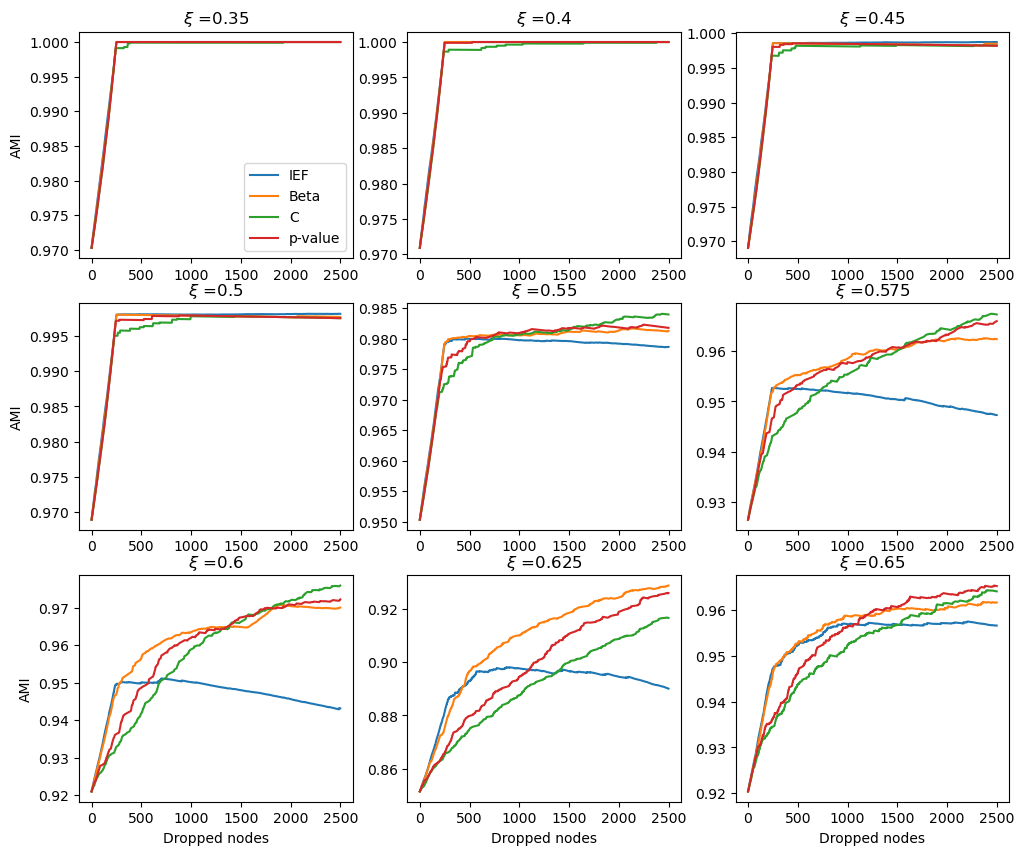

In [6]:
## Scores - only dropping 'outliers'
XIs = [.35,.4,.45,.5,.55,.575,.6,.625,.65]
REP = 1
L = []
for i in range(len(XIs)):
    xi = XIs[i]
    print(xi)
    for rep in range(REP):
        g = readGraph(xi=xi, eta=1.0, rep=rep+1)
        num_nodes = g.vcount()
        A = g.get_adjacency_sparse()
        g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
        g.vs['gt'] = [x[0] for x in g.vs['comms']]
        ## Compute Beta, C; M is the community membership matrix w.r.t. C and c_star 
        IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
        g.vs['IEF'] = IEF.max(axis=1).toarray().flatten()
        g.vs['beta'] = Beta.max(axis=1).toarray().flatten()
        g.vs['C'] = C.max(axis=1).toarray().flatten()
        g.vs['P'] = P.max(axis=1).toarray().flatten()

        ## rank w.r.t. top score, AMI w.r.t. original partition
        r = np.argsort(g.vs['IEF'])
        for k in range(num_nodes//4):
            L.append([xi, 'IEF', k, AMI( np.array(g.vs['leiden'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['beta'])
        for k in range(num_nodes//4):
            L.append([xi, 'beta', k, AMI( np.array(g.vs['leiden'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['C'])
        for k in range(num_nodes//4):
            L.append([xi, 'C', k, AMI( np.array(g.vs['leiden'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['P'])
        for k in range(num_nodes//4):
            L.append([xi, 'P', k, AMI( np.array(g.vs['leiden'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        

plt.figure(figsize=(12,10))
df = pd.DataFrame(L, columns=['xi','algo','dropped','ami']) 
for i in range(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    D = df[df.xi==XIs[i]]
    D = D.groupby(by=['dropped','algo'])['ami'].mean()
    plt.plot(D.loc[:,'IEF'].index, D.loc[:,'IEF'], label='IEF')
    plt.plot(D.loc[:,'beta'].index, D.loc[:,'beta'], label='Beta')
    plt.plot(D.loc[:,'C'].index, D.loc[:,'C'], label='C')
    plt.plot(D.loc[:,'P'].index, D.loc[:,'P'], label='p-value')
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('Dropped nodes')
    if i%3==0:
        plt.ylabel('AMI');
    plt.title(r'$\xi$ ='+str(xi))
#plt.savefig('AMI_leiden.png');


0.35
0.4
0.45
0.5
0.55
0.575
0.6
0.625
0.65


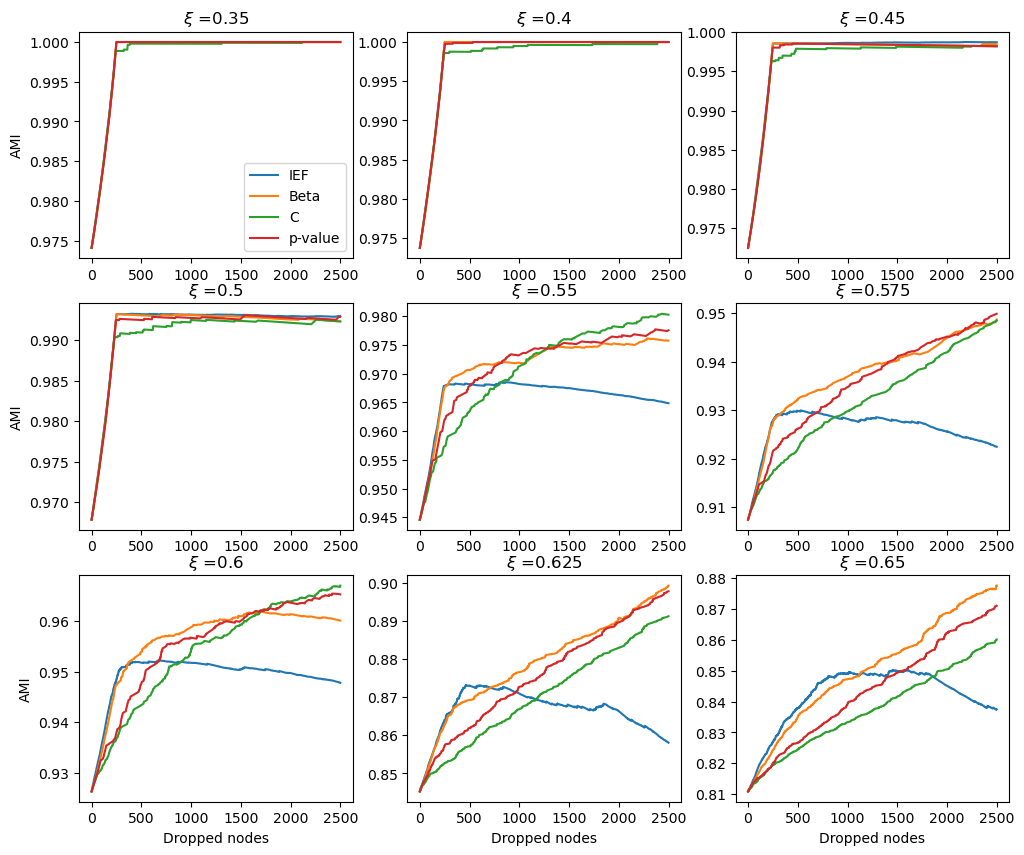

In [85]:
## Scores - using those
L = []
for i in range(len(XIs)):
    xi = XIs[i]
    print(xi)
    for rep in range(REP):
        g = readGraph(xi=xi, eta=1.0, rep=rep+1)
        num_nodes = g.vcount()
        A = g.get_adjacency_sparse()
        g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
        g.vs['gt'] = [x[0] for x in g.vs['comms']]
        ## Compute Beta, C; M is the community membership matrix w.r.t. C and c_star 
        IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
        g.vs['IEF'] = IEF.max(axis=1).toarray().flatten()
        g.vs['IEF_top'] = np.array(IEF.argmax(axis=1)).flatten()
        g.vs['beta'] = Beta.max(axis=1).toarray().flatten()
        g.vs['beta_top'] = np.array(IEF.argmax(axis=1)).flatten()
        g.vs['C'] = C.max(axis=1).toarray().flatten()
        g.vs['C_top'] = np.array(IEF.argmax(axis=1)).flatten()
        g.vs['P'] = P.max(axis=1).toarray().flatten()
        g.vs['P_top'] = np.array(IEF.argmax(axis=1)).flatten()

        ## rank w.r.t. top score, AMI w.r.t. original partition
        r = np.argsort(g.vs['IEF'])
        for k in range(num_nodes//4):
            L.append([xi, 'IEF', k, AMI( np.array(g.vs['IEF_top'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['beta'])
        for k in range(num_nodes//4):
            L.append([xi, 'beta', k, AMI( np.array(g.vs['beta_top'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['C'])
        for k in range(num_nodes//4):
            L.append([xi, 'C', k, AMI( np.array(g.vs['C_top'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['P'])
        for k in range(num_nodes//4):
            L.append([xi, 'P', k, AMI( np.array(g.vs['P_top'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        

plt.figure(figsize=(12,10))
df = pd.DataFrame(L, columns=['xi','algo','dropped','ami']) 
for i in range(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    D = df[df.xi==XIs[i]]
    D = D.groupby(by=['dropped','algo'])['ami'].mean()
    plt.plot(D.loc[:,'IEF'].index, D.loc[:,'IEF'], label='IEF')
    plt.plot(D.loc[:,'beta'].index, D.loc[:,'beta'], label='Beta')
    plt.plot(D.loc[:,'C'].index, D.loc[:,'C'], label='C')
    plt.plot(D.loc[:,'P'].index, D.loc[:,'P'], label='p-value')
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('Dropped nodes')
    if i%3==0:
        plt.ylabel('AMI');
    plt.title(r'$\xi$ ='+str(xi))
#plt.savefig('AMI_scores.png');


### (2) Classify outliers - ROC curves

* now using larger eta value (choices: 1.0, 1.5, 2.0, 2.5, 3.0)

In [236]:
num_out = 250

In [242]:
ETA = 3.0

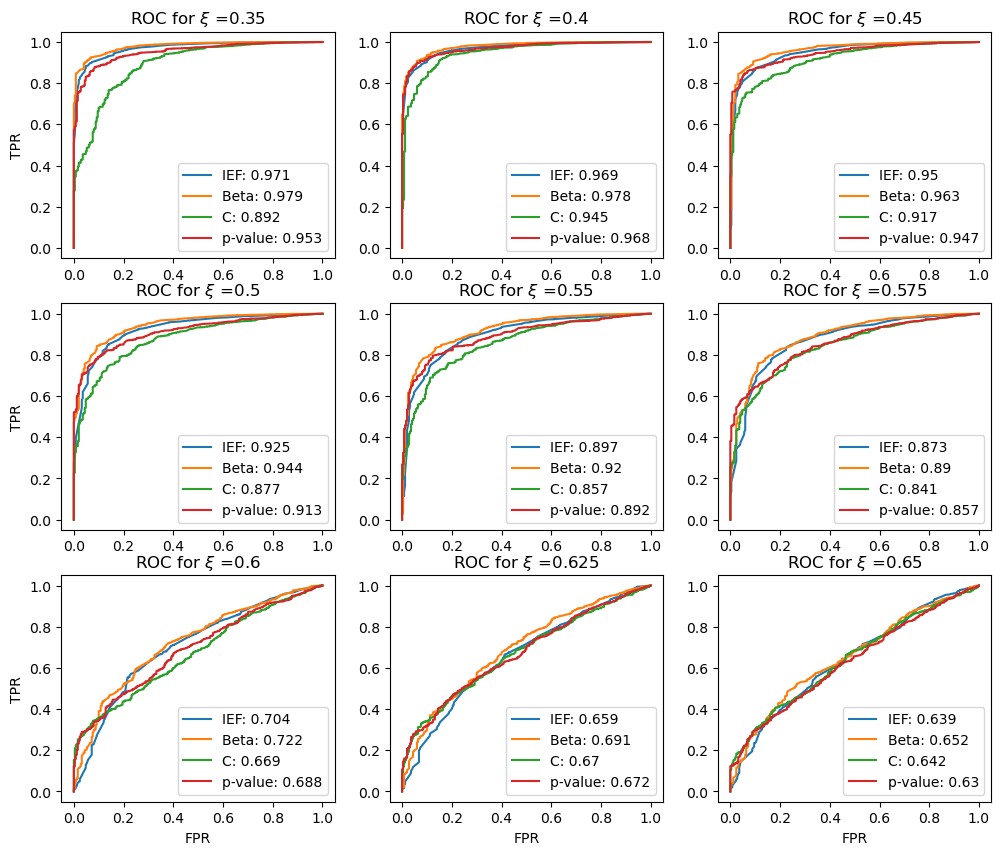

In [243]:
plt.figure(figsize=(12,10))

for i in range(len(XIs)): 
    xi = XIs[i]
    g = readGraph(xi=xi, eta=ETA, rep=1)
    g.vs['gt'] = [x[0] for x in g.vs['comms']] ## pick the first; 0 == outlier
    A = g.get_adjacency_sparse()
    ## Leiden:
    g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
    IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
    plt.subplot(3,3,i+1)

    y = [int(x>0) for x in g.vs['gt']]

    g.vs['IEF'] = IEF.max(axis=1).toarray().flatten()
    fpr, tpr, thresholds = roc_curve(y, g.vs['IEF'], pos_label=1)
    auc = AUC(y, g.vs['IEF'])
    plt.plot(fpr, tpr, label='IEF: '+str(round(auc,3)))

    g.vs['beta'] = Beta.max(axis=1).toarray().flatten()
    fpr, tpr, thresholds = roc_curve(y, g.vs['beta'], pos_label=1)
    auc = AUC(y, g.vs['beta'])
    plt.plot(fpr, tpr, label='Beta: '+str(round(auc,3)))

    g.vs['C'] = C.max(axis=1).toarray().flatten()
    fpr, tpr, thresholds = roc_curve(y, g.vs['C'], pos_label=1)
    auc = AUC(y, g.vs['C'])
    plt.plot(fpr, tpr, label='C: '+str(round(auc,3)))

    g.vs['P'] = P.max(axis=1).toarray().flatten()
    fpr, tpr, thresholds = roc_curve(y, g.vs['P'], pos_label=1)
    auc = AUC(y, g.vs['P'])
    plt.plot(fpr, tpr, label='p-value: '+str(round(auc,3)))

    plt.legend(title='AUC')
    if i>5:
        plt.xlabel('FPR')
    if i%3==0:
        plt.ylabel('TPR');
    plt.legend()
    plt.title(r'ROC for $\xi$ ='+str(xi))  
plt.savefig('abcdoo_ROC_scores_eta_3_0.png')    


### (3) Scores, varying threshold

In [388]:
ETA = 1.0

In [389]:
%%time

range_IEF = np.arange(.05,.501,.025)
range_beta = np.arange(.05,.501,.025)
range_C = np.arange(1,8.001,.25)
range_P = np.arange(.90,1,.0025)

L = []
for xi in XIs:
    g = readGraph(xi=xi, eta=ETA, rep=1)
    g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
    g.vs['gt'] = [x[0] for x in g.vs['comms']] ## pick the first; 0 == outlier
    A = g.get_adjacency_sparse()
    IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
#     for th in range_IEF:
#         M = score_to_memberships(IEF, DegPart, th)
#         L.append(['IEF', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])
    for th in range_beta:
        M = score_to_memberships(Beta, DegPart, th)
        L.append(['Beta', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])
#     for th in range_C:
#         M = score_to_memberships(C, DegPart, th)
#         L.append(['C', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])
#     for th in range_P:
#         M = score_to_memberships(P, DegPart, th)
#         L.append(['P', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])

df = pd.DataFrame(L, columns=['score','xi','threshold','outliers','TP'])
df['FP'] = df['outliers'] - df['TP']


CPU times: user 49.5 s, sys: 16 ms, total: 49.5 s
Wall time: 49.5 s


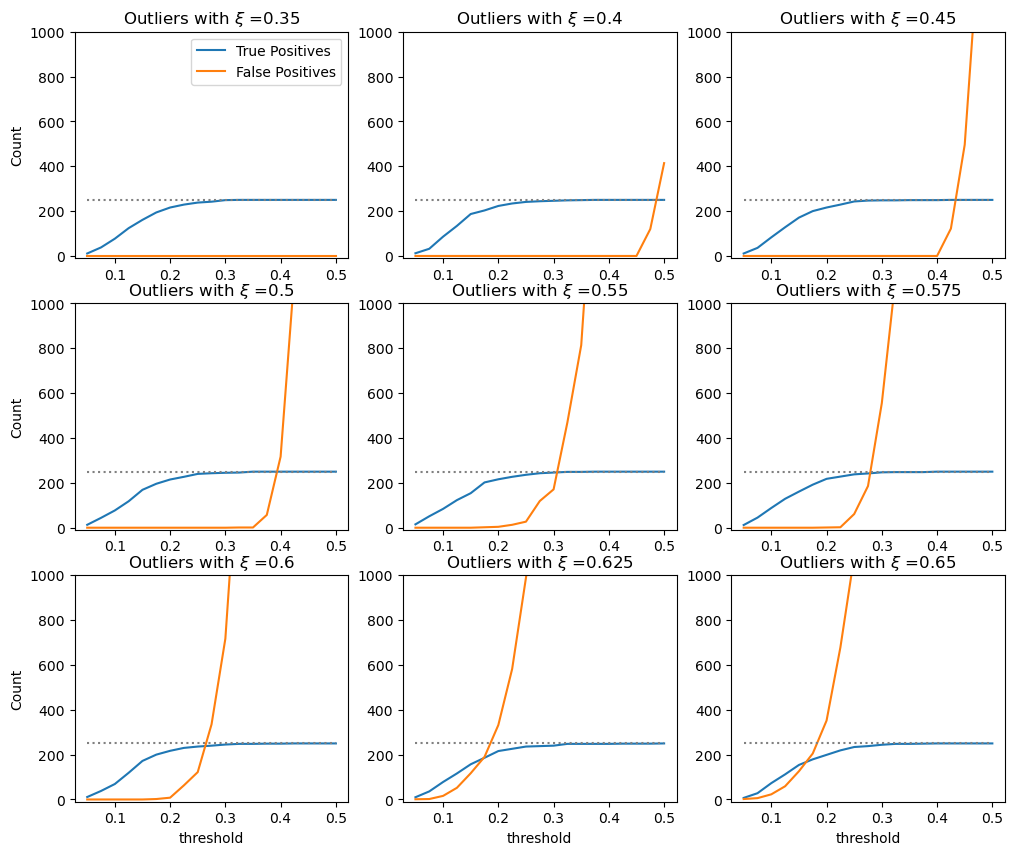

In [390]:
_df = df[df.score == 'Beta']

plt.figure(figsize=(12,10))

for i in range(len(XIs)):
    xi = XIs[i]
    D = _df[_df.xi == xi]
    plt.subplot(3,3,i+1)
    plt.plot(D.threshold, D.TP, label='True Positives')
    plt.plot(D.threshold, D.FP, label='False Positives')
    plt.hlines(y=num_out, xmin=min(D.threshold), xmax=max(D.threshold), linestyles='dotted', color='grey')
    plt.ylim((-10,1000))
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('threshold')
    if i%3==0:
        plt.ylabel('Count');
    plt.title(r'Outliers with $\xi$ ='+str(xi)) 
#plt.savefig('abcdoo_TP_FP_Beta_eta_3_0.png');    


## More tests - as with DBLP


In [267]:
XI = 0.35
ETA = 1.5
REP = 1


In [268]:
G = readGraph(xi=XI, eta=ETA, rep=REP)
G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
G.vs['gt'] = [x[0] for x in G.vs['comms']] ## pick the first; 0 == outlier
## Add community degrees to G (deg_A(v)'s)
for v in G.vs:
    ctr = Counter([i for x in v.neighbors() for i in x['comms']])
    v['degrees'] = [ctr[i] if i in ctr.keys() else 0 for i in v['comms'] ]


In [269]:
A = G.get_adjacency_sparse()
IEF, Beta, C, Pv, DegPart = CAS(A, partition2sparse(G.vs['leiden']), alpha=1)

In [270]:
## Thresholds below are somewhat arbitrary

M = score_to_memberships(IEF, DegPart, threshold=.25)
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('IEF:')
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([G.vs[i]['gt']==0 for i in outliers]))

M = score_to_memberships(Beta, DegPart, threshold=.25)
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('\nBeta score:')
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([G.vs[i]['gt']==0 for i in outliers]))

M = score_to_memberships(C, DegPart, threshold=3)
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('\nC score:')
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([G.vs[i]['gt']==0 for i in outliers]))

M = score_to_memberships(Pv, DegPart, threshold=.95)
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('\np-value score:')
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([G.vs[i]['gt']==0 for i in outliers]))


IEF:
outliers found: 171
ground-truth outliers found: 150

Beta score:
outliers found: 540
ground-truth outliers found: 236

C score:
outliers found: 311
ground-truth outliers found: 175

p-value score:
outliers found: 167
ground-truth outliers found: 131


# Experiment with overlapping ground-truth (gt) communities

* Input: membership (sparse) matrix M and (Sparse) adjacency A


CPU times: user 1min 1s, sys: 92 ms, total: 1min 1s
Wall time: 1min 1s


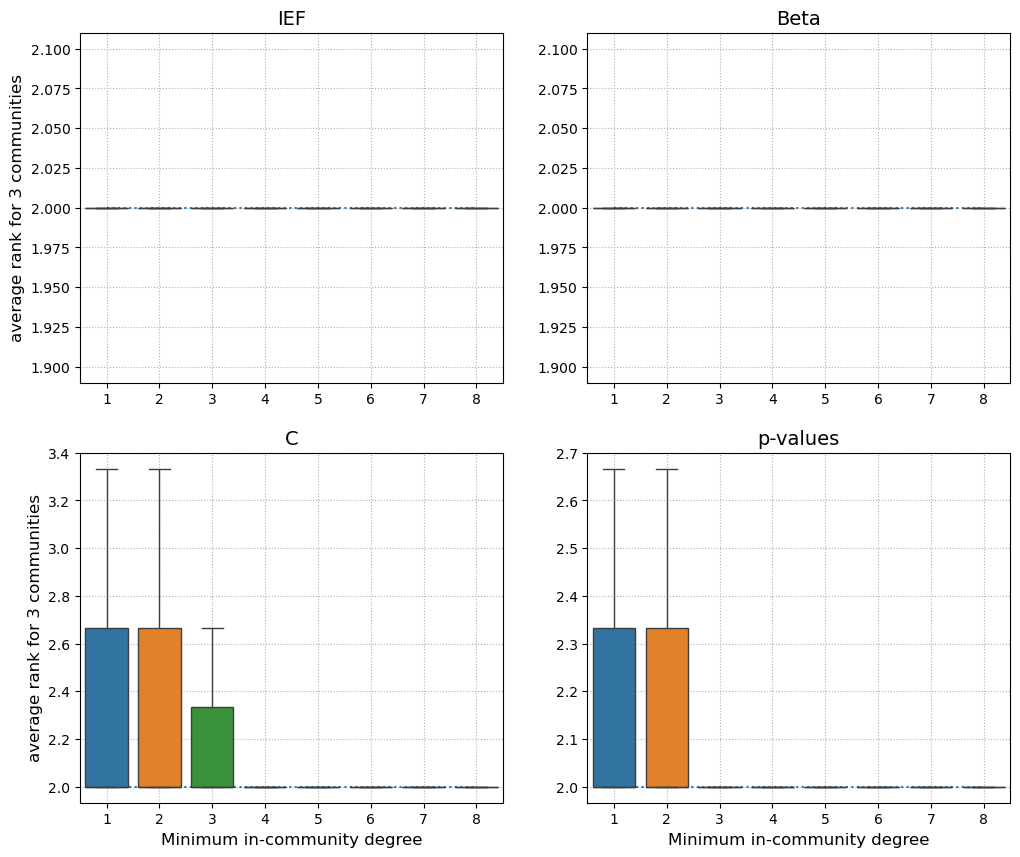

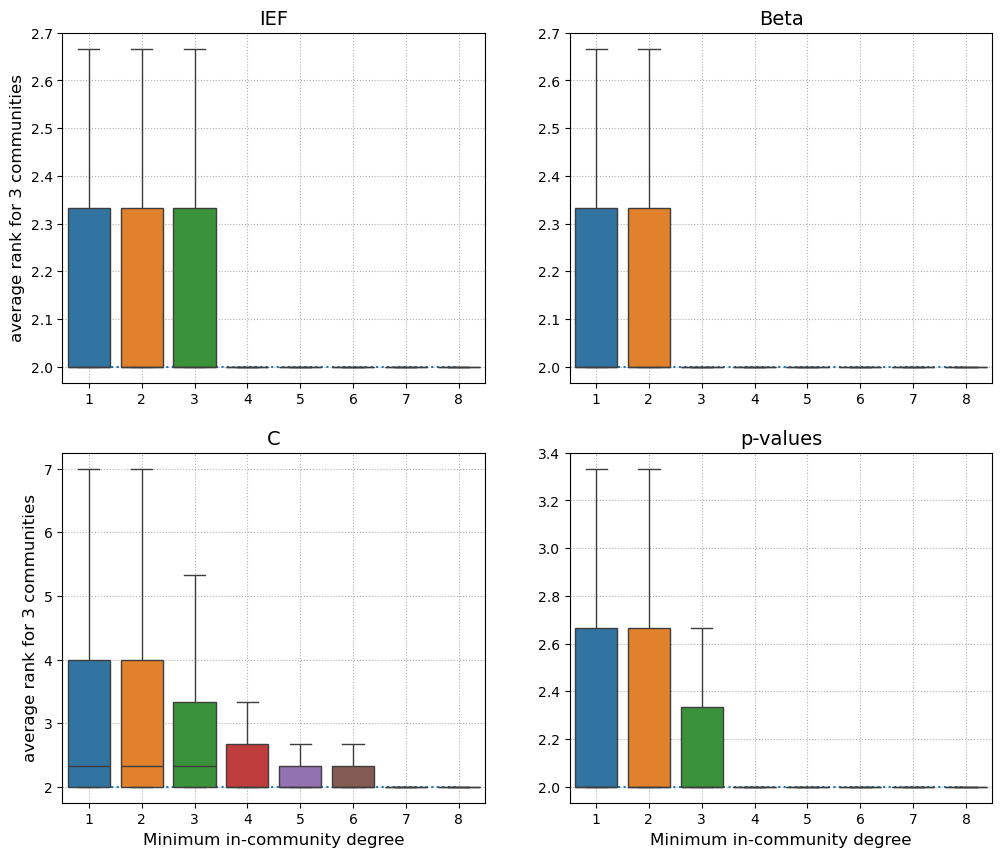

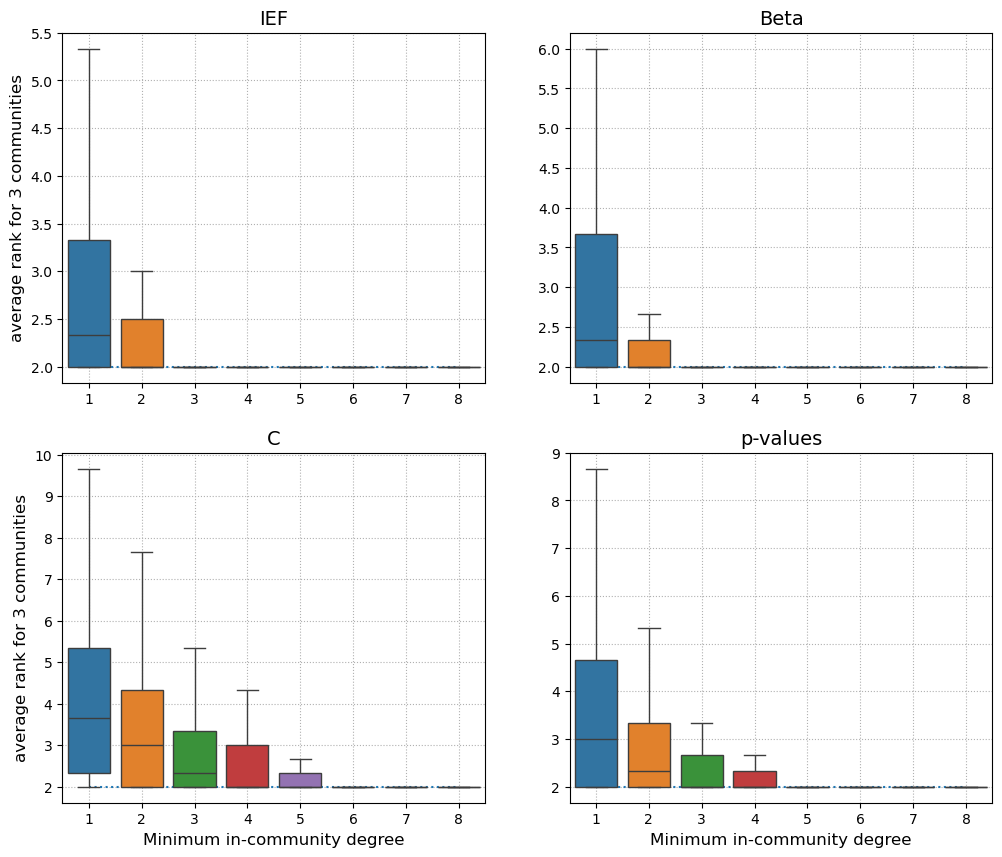

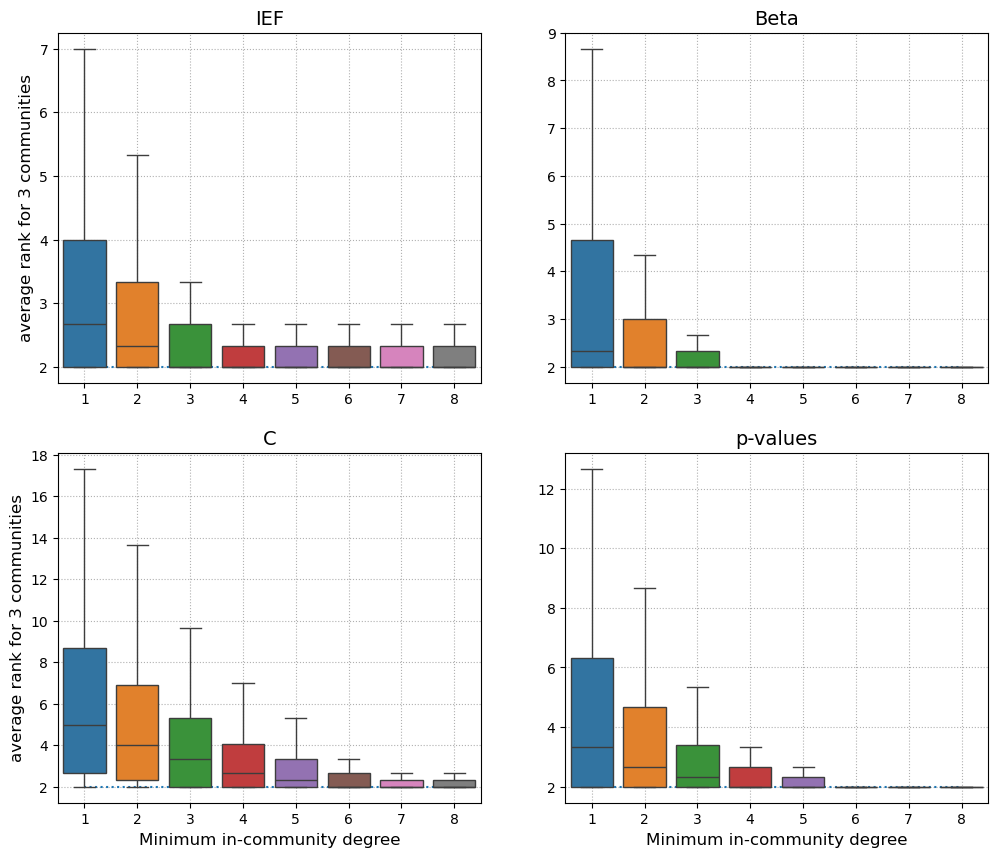

In [279]:
%%time
plt.style.use('default')
K = 3
for xi in [0.4,0.65]:
    for eta in [1.5,3.0]:
        G = readGraph(xi=xi, eta=eta, rep=1)
        G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
        G.vs['gt'] = [x[0] for x in G.vs['comms']] ## pick the first; 0 == outlier

        ## Add community degrees to G (deg_A(v)'s)
        for v in G.vs:
            ctr = Counter([i for x in v.neighbors() for i in x['comms']])
            v['degrees'] = [ctr[i] if i in ctr.keys() else 0 for i in v['comms'] ]

        ## GT community membership matrix
        X = np.repeat(np.arange(G.vcount(), dtype=int), G.vs['n_comms'])
        Y = np.array([i for j in G.vs['comms'] for i in j])
        n = len(X)
        M = sparse.csr_matrix( (np.repeat(1,n), (X,Y)), shape=(G.vcount(), max(Y)+1) )
        A = G.get_adjacency_sparse()

        ## Compute CAS measures
        IEF, Beta, C, Pv, DegPart = CAS(A, M, alpha=1)
        
        ## compute average 
        V = np.array(G.vs['n_comms']) == K
        GT = np.array([G.vs[v]['comms'] for v in np.where(V)])[0] 
        Degs = np.array([G.vs[v]['degrees'] for v in np.where(V)])[0]        

        plt.figure(figsize=(12,10))
        ## IEF
        X = IEF[V]
        L = []
        for i in range(GT.shape[0]):
            x = np.argsort(X[i].toarray()[0])[::-1]
            L.append([np.where(x==GT[i][j])[0][0] for j in range(K) ])
        df = pd.DataFrame(np.array(L)+1)
        my_dict = {}
        for j in [1,2,3,4,5,6,7,8]:
            _df = df[np.min(Degs, axis=1) >= j]
            x = _df.mean(axis=1)
            my_dict[str(j)] = list(x)
        plt.subplot(221)
        plt.hlines((K+1)/2,0,7,linestyles='dotted')
        ax = sns.boxplot([x for x in my_dict.values()], showfliers=False, );
        ax.set_xticks(np.arange(8))
        ax.grid(linestyle=':')
        ax.set_xticklabels(my_dict.keys())
        plt.ylabel('average rank for '+str(K)+' communities', fontsize=12);
        plt.title('IEF', fontsize=14);

        ## Beta
        X = Beta[V]
        L = []
        for i in range(GT.shape[0]):
            x = np.argsort(X[i].toarray()[0])[::-1]
            L.append([np.where(x==GT[i][j])[0][0] for j in range(K) ])
        df = pd.DataFrame(np.array(L)+1)
        my_dict = {}
        for j in [1,2,3,4,5,6,7,8]:
            _df = df[np.min(Degs, axis=1) >= j]
            x = _df.mean(axis=1)
            my_dict[str(j)] = list(x)
        plt.subplot(222)
        plt.hlines((K+1)/2,0,7,linestyles='dotted')
        ax = sns.boxplot([x for x in my_dict.values()], showfliers=False, );
        ax.set_xticks(np.arange(8))
        ax.grid(linestyle=':')
        ax.set_xticklabels(my_dict.keys())
        #plt.xlabel('min community degree at least');
        #plt.ylabel('average rank for '+str(K)+' communities');
        plt.title('Beta', fontsize=14);

        ## C
        X = C[V]
        L = []
        for i in range(GT.shape[0]):
            x = np.argsort(X[i].toarray()[0])[::-1]
            L.append([np.where(x==GT[i][j])[0][0] for j in range(K) ])
        df = pd.DataFrame(np.array(L)+1)
        my_dict = {}
        for j in [1,2,3,4,5,6,7,8]:
            _df = df[np.min(Degs, axis=1) >= j]
            x = _df.mean(axis=1)
            my_dict[str(j)] = list(x)
        plt.subplot(223)
        plt.hlines((K+1)/2,0,7,linestyles='dotted')
        ax = sns.boxplot([x for x in my_dict.values()], showfliers=False, );
        ax.set_xticks(np.arange(8))
        ax.grid(linestyle=':')
        ax.set_xticklabels(my_dict.keys())
        plt.xlabel('Minimum in-community degree', fontsize=12);
        plt.ylabel('average rank for '+str(K)+' communities', fontsize=12);
        plt.title('C', fontsize=14);

        ## Pv
        X = Pv[V]
        L = []
        for i in range(GT.shape[0]):
            x = np.argsort(X[i].toarray()[0])[::-1]
            L.append([np.where(x==GT[i][j])[0][0] for j in range(K) ])
        df = pd.DataFrame(np.array(L)+1)
        my_dict = {}
        for j in [1,2,3,4,5,6,7,8]:
            _df = df[np.min(Degs, axis=1) >= j]
            x = _df.mean(axis=1)
            my_dict[str(j)] = list(x)
        plt.subplot(224)
        plt.hlines((K+1)/2,0,7,linestyles='dotted')
        ax = sns.boxplot([x for x in my_dict.values()], showfliers=False, );
        ax.set_xticks(np.arange(8))
        ax.grid(linestyle=':')
        ax.set_xticklabels(my_dict.keys())
        plt.xlabel('Minimum in-community degree', fontsize=12);
        #plt.ylabel('average rank for '+str(K)+' communities');
        plt.title('p-values', fontsize=14);

        ## save PNG
        fn = 'abcdoo_'+str(xi)+'_'+str(eta)+'_'+str(K)+'.png'
        plt.savefig(fn)


In [409]:
G = readGraph(xi=0.5, eta=1.5, rep=1)
G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
G.vs['gt'] = [x[0] for x in G.vs['comms']] ## pick the first; 0 == outlier
## Add community degrees to G (deg_A(v)'s)
for v in G.vs:
    ctr = Counter([i for x in v.neighbors() for i in x['comms']])
    v['degrees'] = [ctr[i] if i in ctr.keys() else 0 for i in v['comms'] ]

MAX = 8
MINDEG = 1


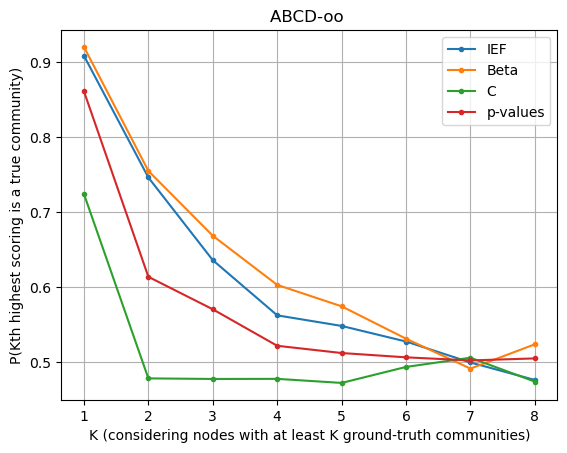

In [309]:
NumIEF = np.zeros(MAX)
NumBeta = np.zeros(MAX)
NumC = np.zeros(MAX)
NumPv = np.zeros(MAX)
Den = np.zeros(MAX)

for K in (np.arange(MAX)+1):
    V = np.array(G.vs['n_comms'])>=K
    minDeg = np.array([min(v['degrees']) if v['n_comms']>0 else 0 for v in G.vs]) >= MINDEG
    V = V & minDeg
    Si = Sb = Sc = Sp = 0
    for i in range(len(V)):
        if V[i]:
            x = np.argsort(IEF[i].toarray()[0])[-K]
            Si += ((x) in G.vs[i]['comms'])
            x = np.argsort(Beta[i].toarray()[0])[-K]
            Sb += ((x) in G.vs[i]['comms'])
            x = np.argsort(C[i].toarray()[0])[-K]
            Sc += ((x) in G.vs[i]['comms'])
            x = np.argsort(Pv[i].toarray()[0])[-K]
            Sp += ((x) in G.vs[i]['comms'])
            
    NumBeta[K-1] = Sb
    NumC[K-1] = Sc
    NumIEF[K-1] = Si
    NumPv[K-1] = Sp
    Den[K-1] = sum(V)

plt.plot(np.arange(MAX)+1, NumIEF/Den, '.-', label='IEF')
plt.plot(np.arange(MAX)+1, NumBeta/Den, '.-', label='Beta')
plt.plot(np.arange(MAX)+1, NumC/Den, '.-', label='C')
plt.plot(np.arange(MAX)+1, NumPv/Den, '.-', label='p-values')
plt.xlabel('K (considering nodes with at least K ground-truth communities)')
plt.ylabel('P(Kth highest scoring is a true community)')
plt.legend()
plt.grid()
plt.title('ABCD-oo ');
fn = 'abcdoo_ranked_0.5_3.0.png'
plt.savefig(fn);


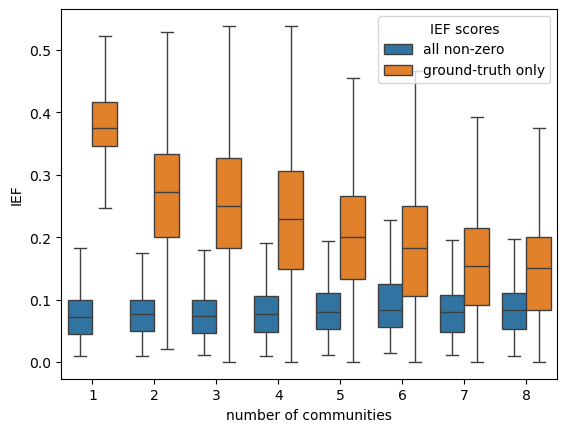

In [310]:
score = []
gt = []
nc = []
for ctr in np.arange(1,MAX+1):
    V = np.array(G.vs['n_comms']) == ctr
    for i in range(len(V)):
        if V[i]:
            x = IEF[i].toarray()[0]
            y = np.array(G.vs[i]['comms'])
            score.extend([x[i] for i in y])
            gt.extend(np.repeat(True,len(y)))
            score.extend(x[x>0])
            gt.extend(np.repeat(False,sum(x>0)))
            nc.extend(np.repeat(ctr,len(y)+sum(x>0)))
D = pd.DataFrame( np.array([score,gt,nc]).transpose(), columns=['IEF','gt','number of communities'])
D['number of communities'] = [int(x) for x in D['number of communities']]
g = sns.boxplot(x='number of communities', y='IEF', hue='gt', data=D, 
                showfliers=False, legend='full')
leg = g.axes.get_legend()
leg.set_title('IEF scores')
new_labels = ['all non-zero','ground-truth only']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
fn = 'abcdoo_ied_0.5_3.0.png'
plt.savefig(fn);


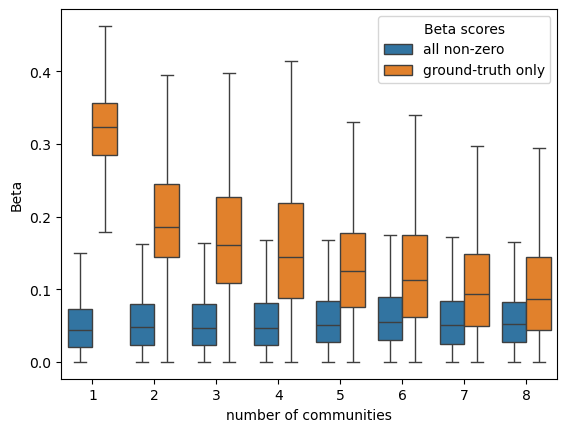

In [311]:
score = []
gt = []
nc = []
for ctr in np.arange(1,MAX+1):
    V = np.array(G.vs['n_comms']) == ctr
    for i in range(len(V)):
        if V[i]:
            x = Beta[i].toarray()[0]
            y = np.array(G.vs[i]['comms'])
            score.extend([x[i] for i in y])
            gt.extend(np.repeat(True,len(y)))
            score.extend(x[x>0])
            gt.extend(np.repeat(False,sum(x>0)))
            nc.extend(np.repeat(ctr,len(y)+sum(x>0)))
D = pd.DataFrame( np.array([score,gt,nc]).transpose(), columns=['Beta','gt','number of communities'])
D['number of communities'] = [int(x) for x in D['number of communities']]
g = sns.boxplot(x='number of communities', y='Beta', hue='gt', data=D, 
                showfliers=False, legend='full')
leg = g.axes.get_legend()
leg.set_title('Beta scores')
new_labels = ['all non-zero','ground-truth only']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
fn = 'abcdoo_beta_0.5_3.0.png'
plt.savefig(fn);


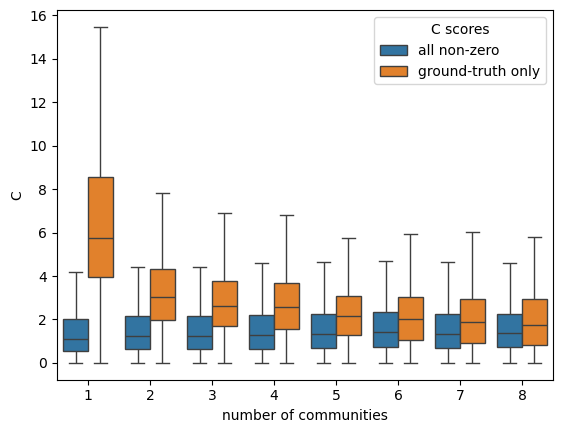

In [312]:
score = []
gt = []
nc = []
for ctr in np.arange(1,MAX+1):
    V = np.array(G.vs['n_comms']) == ctr
    for i in range(len(V)):
        if V[i]:
            x = C[i].toarray()[0]
            y = np.array(G.vs[i]['comms'])
            score.extend([x[i] for i in y])
            gt.extend(np.repeat(True,len(y)))
            score.extend(x[x>0])
            gt.extend(np.repeat(False,sum(x>0)))
            nc.extend(np.repeat(ctr,len(y)+sum(x>0)))
D = pd.DataFrame( np.array([score,gt,nc]).transpose(), columns=['C','gt','number of communities'])
D['number of communities'] = [int(x) for x in D['number of communities']]
g = sns.boxplot(x='number of communities', y='C', hue='gt', data=D, 
                showfliers=False, legend='full')
leg = g.axes.get_legend()
leg.set_title('C scores')
new_labels = ['all non-zero','ground-truth only']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
fn = 'abcdoo_c_0.5_3.0.png'
plt.savefig(fn);


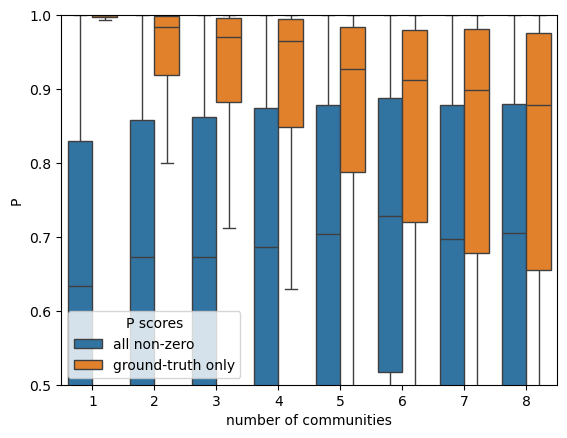

In [313]:
score = []
gt = []
nc = []
for ctr in np.arange(1,MAX+1):
    V = np.array(G.vs['n_comms']) == ctr
    for i in range(len(V)):
        if V[i]:
            x = Pv[i].toarray()[0]
            y = np.array(G.vs[i]['comms'])
            score.extend([x[i] for i in y])
            gt.extend(np.repeat(True,len(y)))
            score.extend(x[x>0])
            gt.extend(np.repeat(False,sum(x>0)))
            nc.extend(np.repeat(ctr,len(y)+sum(x>0)))
D = pd.DataFrame( np.array([score,gt,nc]).transpose(), columns=['P','gt','number of communities'])
D['number of communities'] = [int(x) for x in D['number of communities']]
g = sns.boxplot(x='number of communities', y='P', hue='gt', data=D, 
                showfliers=False, legend='full')
leg = g.axes.get_legend()
leg.set_title('P scores')
new_labels = ['all non-zero','ground-truth only']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
plt.ylim(.5,1);
fn = 'abcdoo_p_0.5_3.0.png'
plt.savefig(fn);


In [314]:
np.mean(G.vs['n_comms'])

2.95

## Testing Rising Tide Stuff

In [410]:
G = readGraph(xi=0.4, eta=1.5, rep=1)
A = G.get_adjacency_sparse()
M = partition2sparse(G.community_leiden(objective_function='modularity').membership)
IEF, Beta, C, Pv, DegPart = CAS(A,M)
Counter(np.array(M.sum(axis=1)).flatten())


Counter({1: 10000})

In [422]:
B = score_to_memberships(Beta, DegPart, threshold=.2, min_deg_in=2)
Counter(np.array(B.sum(axis=1)).flatten())


Counter({1: 9478, 0: 316, 2: 206})

In [423]:
Counter(G.vs['n_comms'] == np.array(B.sum(axis=1)).flatten())

Counter({True: 7820, False: 2180})

In [424]:
RT = rising_tide(A, Beta, min_deg_in=2)
Counter(np.array(RT.sum(axis=1)).flatten())


Counter({3: 3459,
         4: 2776,
         2: 1842,
         5: 1144,
         6: 332,
         1: 290,
         7: 98,
         8: 40,
         9: 10,
         10: 4,
         11: 3,
         0: 2})

In [425]:
Counter(G.vs['n_comms'] == np.array(RT.sum(axis=1)).flatten())

Counter({False: 9314, True: 686})

In [421]:
Counter(np.array(RT.sum(axis=1)).flatten())


Counter({5: 2377,
         6: 1838,
         4: 1584,
         7: 1292,
         8: 884,
         9: 561,
         3: 417,
         10: 385,
         11: 251,
         12: 185,
         13: 114,
         14: 49,
         2: 28,
         15: 20,
         16: 11,
         17: 2,
         1: 2})

In [399]:
G.vs['gt'] = [x[0] for x in G.vs['comms']]

In [400]:
AMI(G.vs['gt'], G.community_leiden(objective_function='modularity').membership)

0.7797644581113936

In [408]:
AMI(G.vs['gt'], np.array(Beta.argmax(axis=1)).flatten())

0.7738350228856626

In [402]:
AMI(G.vs['gt'], np.array(RT.argmax(axis=1)).flatten())

0.25972638768677875

## Testing edges

In [571]:
G = readGraph(xi=0.4, eta=1.5, rep=1)
## GT community membership matrix
X = np.repeat(np.arange(G.vcount(), dtype=int), G.vs['n_comms'])
Y = np.array([i for j in G.vs['comms'] for i in j])
n = len(X)
M = sparse.csr_matrix( (np.repeat(1,n), (X,Y)), shape=(G.vcount(), max(Y)+1) )
A = G.get_adjacency_sparse()

## Compute CAS measures
IEF, Beta, C, Pv, DegPart = CAS(A, M, alpha=1)


In [572]:
## Add community degrees to G (deg_A(v)'s)
for v in G.vs:
    ctr = Counter([i for x in v.neighbors() for i in x['comms']])
    v['degrees'] = [ctr[i] if i in ctr.keys() else 0 for i in v['comms'] ]
## set outliers to 0
b = np.where(np.array([x[0]==0 for x in G.vs['comms']]))[0]
for i in b:
    G.vs[i]['n_comms'] = 0
    

In [587]:
Score = []
Inter = []
for e in G.es:
    Score.append(np.max(np.minimum(np.array(Beta[e.source].todense())[0], np.array(Beta[e.target].todense())[0])))
    Inter.append(len(set(G.vs[e.source]['comms']).intersection(set(G.vs[e.target]['comms']))))


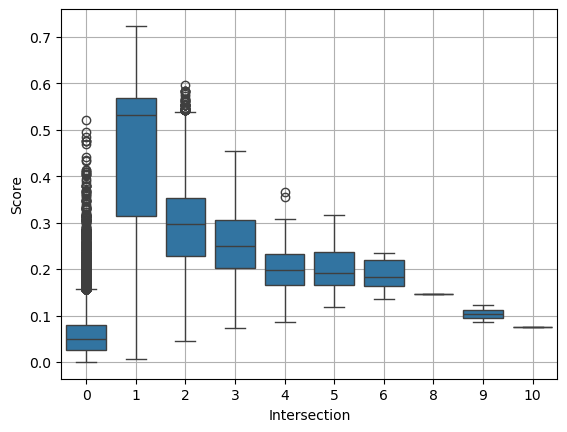

In [595]:
df = pd.DataFrame()
df['Score'] = Score
df['Intersection'] = Inter
sns.boxplot(y='Score', x='Intersection', data=df)
plt.grid();


In [596]:
## Leiden
M = partition2sparse(G.community_leiden(objective_function='modularity').membership)
IEF, Beta, C, Pv, DegPart = CAS(A,M)


In [597]:
Score = []
Inter = []
for e in G.es:
    Score.append(np.max(np.minimum(np.array(Beta[e.source].todense())[0], np.array(Beta[e.target].todense())[0])))
    Inter.append(len(set(G.vs[e.source]['comms']).intersection(set(G.vs[e.target]['comms']))))


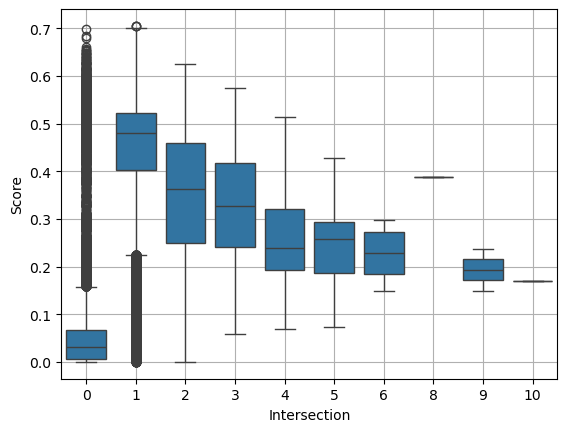

In [598]:
df = pd.DataFrame()
df['Score'] = Score
df['Intersection'] = Inter
sns.boxplot(y='Score', x='Intersection', data=df)
plt.grid();


In [604]:
## drop edges
E = np.where(np.array(Score)<.1)[0]
G.delete_edges(E)

In [608]:
G.vs['gt'] = [x[0] for x in G.vs['comms']]

In [609]:
AMI(G.vs['gt'], G.community_leiden(objective_function='modularity').membership)

0.7834371865077141

In [611]:
Counter(G.vs['n_comms'])

Counter({1: 7735,
         2: 763,
         3: 531,
         4: 287,
         0: 250,
         5: 224,
         6: 127,
         7: 26,
         8: 18,
         12: 12,
         9: 11,
         10: 9,
         11: 5,
         13: 2})

In [612]:
Counter(Inter)

Counter({1: 58617,
         0: 39498,
         2: 2237,
         3: 737,
         4: 138,
         5: 90,
         6: 23,
         9: 2,
         10: 1,
         8: 1})